# CMS Doublets Verisi ile PINN ve Pure NN Karşılaştırması  
### Atınç Baş – Bitirme Projesi Çalışma Notları

In [ ]:
!git clone https://github.com/cernopendata-datascience/CNNPixelSeedsMachineLearning.git
%cd CNNPixelSeedsMachineLearning

Cloning into 'CNNPixelSeedsMachineLearning'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 54 (delta 2), reused 0 (delta 0), pack-reused 48 (from 1)
Receiving objects: 100% (54/54), 395.95 KiB | 43.99 MiB/s, done.
Resolving deltas: 100% (24/24), done.
/content/CNNPixelSeedsMachineLearning


In [ ]:
!pip install tables

from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


## 1. Veri
CERN CMS TTbar_PU50_pixelTracksDoublets verisinin ~500k satırlık kısmı kullanıldı.


In [ ]:
!wget -O TTbar_PU50_pixelTracksDoublets_0_final.h5 "http://opendata.cern.ch/eos/opendata/cms/datascience/CNNPixelSeedsProducerTool/TTbar_13TeV_PU50_PixelSeeds/TTbar_PU50_pixelTracksDoublets_0_final.h5"

import os
import pandas as pd

hdf_path = "TTbar_PU50_pixelTracksDoublets_0_final.h5"
parquet_path = "TTbar_PU50_pixelTracksDoublets_0_final.parquet"

# Hangi key altında kayıtlı olduğunu öğren
store = pd.HDFStore(hdf_path, mode="r")
print("HDF keys:", store.keys())
key = store.keys()[0]   # genelde tek key var, örn. '/table'
store.close()

if not os.path.exists(parquet_path):
    print("➡️ HDF dosyası Parquet'e çevriliyor (bu hücreyi bir kere çalıştırman yeterli)...")
    # Tüm satırları oku (milyon mertebesi için Colab'de sorun olmaz)
    df_full = pd.read_hdf(hdf_path, key=key)
    print("Tam veri shape:", df_full.shape)

    # Sadece ihtiyacın olan kolonları bırakmak istersen:
    # feature_cols ve target_cols ileride tanımlanıyor, şimdilik yorum satırında dursun.
    # keep_cols = feature_cols + target_cols + ["label"] vs. varsa
    # df_full = df_full[keep_cols]

    df_full.to_parquet(parquet_path, index=False)
    print("✅ Parquet kaydedildi:", parquet_path)
else:
    print("Parquet zaten var, tekrar üretmeye gerek yok ->", parquet_path)

--2025-12-24 07:38:22--  http://opendata.cern.ch/eos/opendata/cms/datascience/CNNPixelSeedsProducerTool/TTbar_13TeV_PU50_PixelSeeds/TTbar_PU50_pixelTracksDoublets_0_final.h5
Resolving opendata.cern.ch (opendata.cern.ch)... 137.138.6.31, 2001:1458:201:8b::100:1c8
Connecting to opendata.cern.ch (opendata.cern.ch)|137.138.6.31|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 657044050 (627M) [application/octet-stream]
Saving to: ‘TTbar_PU50_pixelTracksDoublets_0_final.h5’

TTbar_PU50_pixelTra 100%[===================>] 626.61M  15.2MB/s    in 44s     

2025-12-24 07:39:07 (14.4 MB/s) - ‘TTbar_PU50_pixelTracksDoublets_0_final.h5’ saved [657044050/657044050]

HDF keys: ['/data']
➡️ HDF dosyası Parquet'e çevriliyor (bu hücreyi bir kere çalıştırman yeterli)...
Tam veri shape: (5381062, 622)
✅ Parquet kaydedildi: TTbar_PU50_pixelTracksDoublets_0_final.parquet


In [ ]:
import pandas as pd

parquet_path = "TTbar_PU50_pixelTracksDoublets_0_final.parquet"

# Tüm veriyi parquetten oku
data_full = pd.read_parquet(parquet_path)
print("Parquet veri shape:", data_full.shape)


"""## 2. Feature ve Target
Giriş: in/out koordinatlar ve PU
Çıkış: outTpPhi, outTpEta
"""

feature_cols = [
    "inX", "inY", "inZ",
    "outX", "outY", "outZ",
    "PU",
    "BunchCrossing",
    "inTpCharge",
    "inTpPt",     # <-- A: eklendi
    "inR",
    "outR"
]

fixed_bz = 3.8112  # CMS Solenoid Field (Tesla) - Varsayılan değer
target_cols = ["outTpPhi", "outTpEta"]

# Kontrol
print([ (c, c in data_full.columns) for c in feature_cols ])
print([ (c, c in data_full.columns) for c in target_cols ])

# İstersen burada alt örnekleme yapabilirsin:
# MAX_SAMPLES = None -> TÜM veriyi kullan
# MAX_SAMPLES = 500_000 -> ilk 500k satırla çalış vs.
MAX_SAMPLES = None

if MAX_SAMPLES is not None:
    data_sample = data_full.iloc[:MAX_SAMPLES].copy()
else:
    data_sample = data_full.copy()

print("Kullanılan veri shape:", data_sample.shape)


Parquet veri shape: (5381062, 622)
[('inX', True), ('inY', True), ('inZ', True), ('outX', True), ('outY', True), ('outZ', True), ('PU', True), ('BunchCrossing', True), ('inTpCharge', True), ('inTpPt', True), ('inR', True), ('outR', True)]
[('outTpPhi', True), ('outTpEta', True)]
Kullanılan veri shape: (5381062, 622)


In [ ]:
print("Toplam kolon sayısı:", len(data_full.columns))
for i, col in enumerate(data_full.columns):
    print(f"{i:03d} | {col}")


Toplam kolon sayısı: 622
000 | run
001 | evt
002 | lumi
003 | PU
004 | bSX
005 | bSY
006 | bSZ
007 | inX
008 | inY
009 | inZ
010 | inPhi
011 | inR
012 | inDetSeq
013 | inIsBarrel
014 | inLayer
015 | inLadder
016 | inSide
017 | inDisk
018 | inPanel
019 | inModule
020 | inIsFlipped
021 | inAx1
022 | inAx2
023 | inClustX
024 | inClustY
025 | inClustSize
026 | inClustSizeX
027 | inClustSizeY
028 | inPixelZero
029 | inAvgCharge
030 | inOverFlowX
031 | inOverFlowY
032 | inSkew
033 | inIsBig
034 | inIsBad
035 | inIsEdge
036 | inPix1
037 | inPix2
038 | inPix3
039 | inPix4
040 | inPix5
041 | inPix6
042 | inPix7
043 | inPix8
044 | inPix9
045 | inPix10
046 | inPix11
047 | inPix12
048 | inPix13
049 | inPix14
050 | inPix15
051 | inPix16
052 | inPix17
053 | inPix18
054 | inPix19
055 | inPix20
056 | inPix21
057 | inPix22
058 | inPix23
059 | inPix24
060 | inPix25
061 | inPix26
062 | inPix27
063 | inPix28
064 | inPix29
065 | inPix30
066 | inPix31
067 | inPix32
068 | inPix33
069 | inPix34
070 | inPix35


In [ ]:
print("inTpCharge unique:", data_sample["inTpCharge"].value_counts(dropna=False).head(10))
print("outTpCharge unique:", data_sample["outTpCharge"].value_counts(dropna=False).head(10))

inTpCharge unique: inTpCharge
-1    3000448
 1    2357391
 0      23223
Name: count, dtype: int64
outTpCharge unique: outTpCharge
-1    3137217
 1    2207594
 0      36251
Name: count, dtype: int64


## 2. Feature ve Target
Giriş: in/out koordinatlar ve PU    
Çıkış: outTpPhi, outTpEta


In [ ]:
X_data = data_sample[feature_cols].to_numpy(dtype=np.float32)
y_data = data_sample[target_cols].to_numpy(dtype=np.float32)

x_mean = X_data.mean(axis=0, keepdims=True)
x_std  = X_data.std(axis=0, keepdims=True) + 1e-6

idx_inR  = feature_cols.index("inR")
idx_outR = feature_cols.index("outR")


X_norm = (X_data - x_mean) / x_std

y_mean = y_data.mean(axis=0, keepdims=True)
y_std  = y_data.std(axis=0, keepdims=True) + 1e-6
y_norm = (y_data - y_mean) / y_std


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_tensor = torch.from_numpy(X_norm).to(device)
y_tensor = torch.from_numpy(y_norm).to(device)

"""
N = min(50000, X_tensor.shape[0])
X_tensor = X_tensor[:N]
y_tensor = y_tensor[:N]
y_true = y_data[:N]
"""

# İstersen buradan tekrar sınır koyabilirsin
MAX_TRAIN_SAMPLES = None   # None -> tüm veriyi kullan

if MAX_TRAIN_SAMPLES is not None:
    N = min(MAX_TRAIN_SAMPLES, X_tensor.shape[0])
else:
    N = X_tensor.shape[0]

X_tensor = X_tensor[:N]
y_tensor = y_tensor[:N]
y_true   = y_data[:N]

print("PINN/NN eğitiminde kullanılacak örnek sayısı N =", N)



PINN/NN eğitiminde kullanılacak örnek sayısı N = 5381062


In [ ]:
from sklearn.model_selection import train_test_split

# Toplam örnek sayısı N üzerinden indeksler
indices = np.arange(N)

# 15% test, geri kalanın içinden 15% validation olacak şekilde iki aşamalı split
idx_trainval, idx_test = train_test_split(indices, test_size=0.15, random_state=42)
idx_train, idx_val = train_test_split(idx_trainval, test_size=0.176, random_state=42)
# 0.176 ≈ 0.15 / 0.85 → toplamda yaklaşık 70/15/15 oranı

X_train = X_tensor[idx_train]
X_val   = X_tensor[idx_val]
X_test  = X_tensor[idx_test]

y_train = y_tensor[idx_train]
y_val   = y_tensor[idx_val]
y_test  = y_tensor[idx_test]

# Denormalize karşılıkları
y_true_train = y_true[idx_train]
y_true_val   = y_true[idx_val]
y_true_test  = y_true[idx_test]

print("Train shape:", X_train.shape, y_train.shape)
print("Val   shape:", X_val.shape,   y_val.shape)
print("Test  shape:", X_test.shape,  y_test.shape)


Train shape: torch.Size([3768895, 12]) torch.Size([3768895, 2])
Val   shape: torch.Size([805007, 12]) torch.Size([805007, 2])
Test  shape: torch.Size([807160, 12]) torch.Size([807160, 2])


## 3. PINN Modeli
FCNN + drift-diffusion PDE residual + (μ, D, E0) inverse parametreleri.


In [ ]:

class FCNN(nn.Module):
    def __init__(self, in_dim, out_dim, hidden_dims=(64, 64, 64), activation=nn.Tanh):
        super().__init__()
        layers = []
        last_dim = in_dim
        for h in hidden_dims:
            layers.append(nn.Linear(last_dim, h))
            layers.append(activation())
            last_dim = h
        layers.append(nn.Linear(last_dim, out_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


In [ ]:
import math
import torch

def wrap_torch(dphi):
    return (dphi + math.pi) % (2*math.pi) - math.pi

class InversePINN(nn.Module):
    def __init__(self, in_dim, charge_index, ptref_index):
        super().__init__()
        self.charge_index = charge_index
        self.ptref_index  = ptref_index

        self.net = FCNN(in_dim, out_dim=6)

        # Ölçek sabiti (birim/param belirsizliği)
        self.kappa = nn.Parameter(torch.tensor(1.0, dtype=torch.float32))

    def forward(self, x):
        return self.net(x)

    """
    def pde_residual(self, x, eps=1e-12):
        x = x.clone().requires_grad_(True)

        u = self.forward(x)  # [N,6]
        Px = u[:, 3]
        Py = u[:, 4]
        Pz = u[:, 5]

        # modelden phi/eta
        phi = torch.atan2(Py, Px)

        # ---------- input truth charge (unnormalize) ----------
        q_norm = x[:, self.charge_index]
        q = q_norm * x_std_t[self.charge_index] + x_mean_t[self.charge_index]

        # ---------- input truth pT (unnormalize) ----------
        ptref_norm = x[:, self.ptref_index]
        pt_ref = ptref_norm * x_std_t[self.ptref_index] + x_mean_t[self.ptref_index]
        pt_ref = torch.clamp(pt_ref.abs(), min=1e-2)  # güvenlik

        # ---------- input Bz from bSZ (unnormalize) ----------
        bz_norm = x[:, self.bSZ_index]
        Bz = bz_norm * x_std_t[self.bSZ_index] + x_mean_t[self.bSZ_index]

        omega = self.kappa * q * Bz / (pt_ref + eps)

        # sin/cos ile stabilize
        c = torch.cos(phi).unsqueeze(1)
        s = torch.sin(phi).unsqueeze(1)

        grad_c = torch.autograd.grad(c, x, torch.ones_like(c), create_graph=True, retain_graph=True)[0]
        grad_s = torch.autograd.grad(s, x, torch.ones_like(s), create_graph=True, retain_graph=True)[0]
        omega_ = omega.unsqueeze(1)

        r1 = dc_ds + s * omega_
        r2 = ds_ds - c * omega_

        # eta sabitliği için eski r3'ü korumak istersen:
        # pt_model = torch.sqrt(Px**2 + Py**2 + eps)
        # eta = torch.asinh(Pz / (pt_model + eps))
        # eta_ = eta.unsqueeze(1)
        # grad_eta = torch.autograd.grad(eta_, x, torch.ones_like(eta_), create_graph=True, retain_graph=True)[0]
        # deta_ds = grad_eta[:, self.coord_index:self.coord_index+1]
        # r3 = deta_ds
        # return torch.cat([r1, r2, r3], dim=1), q

        return torch.cat([r1, r2], dim=1), q   # [N,2], q
        """


    def pde_residual_total(self, xb_norm, fixed_bz=3.81, eps=1e-12):
        """
        Toplam türev: tau leaf değişkeni ile x(tau) kurulur ve autograd ile d/dtau alınır.
        R-parametrizasyon: R(tau) = inR + tau*(outR-inR)
        PDE: d/dR sin/cos sistemi -> tau'ya ölçeklenmiş residual
        """
        # 1) unnormalize base batch
        xb0 = xb_norm * x_std_t + x_mean_t   # [N, in_dim]
        N = xb0.size(0)

        # 2) leaf tau in (0,1)
        tau = torch.rand((N,), device=xb0.device, dtype=xb0.dtype, requires_grad=True)  # [N]

        # 3) segment endpoints (base)
        inX  = xb0[:, idx_inX];  inY  = xb0[:, idx_inY];  inZ  = xb0[:, idx_inZ]
        outX0 = xb0[:, idx_outX]; outY0 = xb0[:, idx_outY]; outZ0 = xb0[:, idx_outZ]

        dx = outX0 - inX
        dy = outY0 - inY
        dz = outZ0 - inZ

        # 4) interpolate current point along the segment (tau)
        outX = inX + tau * dx
        outY = inY + tau * dy
        outZ = inZ + tau * dz

        # 5) R(tau) using inR/outR
        inR  = xb0[:, idx_inR]
        outR0 = xb0[:, idx_outR]

        # --- EKSİK PARÇA 1: dR HESABI ---
        # Zincir kuralı için R farkına ihtiyacımız var (dR/dtau = outR - inR)
        diff_R = outR0 - inR

        R = inR + tau * diff_R

        # 6) build xb(tau) (still in physical units), keep other features same
        xb = xb0.clone()
        xb[:, idx_outX] = outX
        xb[:, idx_outY] = outY
        xb[:, idx_outZ] = outZ
        # Also write R into outR (optional, but consistent)
        xb[:, idx_outR] = R

        # 7) normalize and forward
        x = (xb - x_mean_t) / x_std_t
        u = self.forward(x)  # [N,6]
        Px = u[:, 3]; Py = u[:, 4]; Pz = u[:, 5]

        phi = torch.atan2(Py, Px)
        c = torch.cos(phi)  # [N]
        s = torch.sin(phi)  # [N]

        # 8) Unnormalize q, pt_ref
        q_norm = x[:, self.charge_index]
        q = q_norm * x_std_t[self.charge_index] + x_mean_t[self.charge_index]

        ptref_norm = x[:, self.ptref_index]
        pt_ref = ptref_norm * x_std_t[self.ptref_index] + x_mean_t[self.ptref_index]
        pt_ref = torch.clamp(pt_ref.abs(), min=1e-2)

        # 9) Omega hesabı ve Bz
        # DÜZELTME: fixed_bz argüman olarak eklendi (varsayılan 3.81 Tesla)
        Bz = fixed_bz

        # omega_R: Radyal mesafeye göre değişim hızı (dPhi / dR)
        omega_R = self.kappa * q * Bz / (pt_ref + eps)

        # --- EKSİK PARÇA 2: Zincir Kuralı (Chain Rule) ---
        # dPhi/dtau = (dPhi/dR) * (dR/dtau)
        # dR/dtau = diff_R (yani outR - inR)
        omega_tau = diff_R * omega_R

        # 10) total derivatives wrt tau
        dc_dtau = torch.autograd.grad(c, tau, grad_outputs=torch.ones_like(c),
                                      create_graph=True, retain_graph=True)[0]  # [N]
        ds_dtau = torch.autograd.grad(s, tau, grad_outputs=torch.ones_like(s),
                                      create_graph=True, retain_graph=True)[0]  # [N]

        # 11) residuals (tau form)
        # Artık omega_tau tanımlı olduğu için burası çalışır
        r1 = dc_dtau + s * omega_tau
        r2 = ds_dtau - c * omega_tau

        res = torch.stack([r1, r2], dim=1)  # [N,2]
        return res, q


In [ ]:
# x_mean, x_std numpy -> torch tensor (device üzerinde)
x_mean_t = torch.tensor(x_mean.squeeze(0), dtype=torch.float32, device=device)
x_std_t  = torch.tensor(x_std.squeeze(0),  dtype=torch.float32, device=device)

y_mean_t = torch.tensor(y_mean.squeeze(0), dtype=torch.float32, device=device)  # [2]
y_std_t  = torch.tensor(y_std.squeeze(0),  dtype=torch.float32, device=device)  # [2]

idx_inX  = feature_cols.index("inX")
idx_inY  = feature_cols.index("inY")
idx_inZ  = feature_cols.index("inZ")
idx_outX = feature_cols.index("outX")
idx_outY = feature_cols.index("outY")
idx_outZ = feature_cols.index("outZ")


def geometry_phi_eta_from_xnorm(xb_norm, eps=1e-12):
    """
    xb_norm: [N,in_dim] (normalize edilmiş)
    return:
      phi_dir, eta_dir  (normalize edilmemiş gerçek açılar, [N])
    """
    xb = xb_norm * x_std_t + x_mean_t  # unnormalize

    dx = xb[:, idx_outX] - xb[:, idx_inX]
    dy = xb[:, idx_outY] - xb[:, idx_inY]
    dz = xb[:, idx_outZ] - xb[:, idx_inZ]
    dr = torch.sqrt(dx*dx + dy*dy) + eps

    phi_dir = torch.atan2(dy, dx)        # [N]
    eta_dir = torch.asinh(dz / dr)       # [N]
    return phi_dir, eta_dir

def phi_angle_mse(phi_pred, phi_tgt):
    d = wrap_torch(phi_pred - phi_tgt)
    return (d*d).mean()


In [ ]:
# =========================
# Animasyon için sabit alt-küme (ör: test setten 2000 örnek)
# =========================
import numpy as np

n_anim = min(2000, len(X_test))
idx_anim = np.random.choice(len(X_test), size=n_anim, replace=False)

X_anim_tensor = X_test[idx_anim]           # cihazda (cuda/cpu) tensor
y_anim_true   = y_true_test[idx_anim]      # denormalize gerçek değerler (numpy)

snapshots_pinn = []  # her eleman: (epoch, y_pred_anim)
snapshots_pure = []
SNAP_EVERY = 5       # her 5 epoch'ta bir kare



In [ ]:
xb = X_train[:2048]
xb_phys = xb * x_std_t + x_mean_t
dR = xb_phys[:, idx_outR] - xb_phys[:, idx_inR]
print("dR min/mean/max:", dR.min().item(), dR.mean().item(), dR.max().item())

dR min/mean/max: 0.5790796279907227 5.378763198852539 13.242439270019531


## 4. PINN Eğitimi
Veri + PDE kaybı birlikte minimize edilir.


In [ ]:
"""## 4. PINN Eğitimi
Veri + PDE kaybı birlikte minimize edilir (train + val + adaptive λ_pde).
"""
DEBUG_PDE = False
DEBUG_ONCE = {"done": False}

pde_ema = None
in_dim = X_tensor.shape[1]
out_dim = y_tensor.shape[1]   # PureNN için


charge_index  = feature_cols.index("inTpCharge")
ptref_index   = feature_cols.index("inTpPt")   # <-- A



model = InversePINN(in_dim, charge_index, ptref_index).to(device)


optimizer = optim.Adam(model.parameters(), lr=1e-3)
mse_loss  = nn.MSELoss()

NUM_EPOCHS_PINN = 100

history_pinn = {
    "epoch": [],
    "train_loss": [],
    "train_data": [],
    "train_geo": [],
    "train_pde": [],
    "val_loss": [],
    "val_data": [],
    "val_geo": [],
    "val_pde": [],
    "lambda_pde": [],
    "lambda_geo": [],
}

lambda_geo = 1.0   # başlangıç
lambda_pde = 1.0   # sende adaptive vardı; aşağıda onu daha doğru kullanacağız
eps = 1e-12


def mom_to_phi_eta(Px, Py, Pz, eps=1e-12):
    pt  = torch.sqrt(Px**2 + Py**2 + eps)
    phi = torch.atan2(Py, Px)
    eta = torch.asinh(Pz / (pt + eps))   # çok daha stabil
    return phi, eta

def pinn_loss(xb, yb):
    # ---- 1) model output ----
    u_pred = model(xb)  # [N,6]
    Px = u_pred[:, 3]
    Py = u_pred[:, 4]
    Pz = u_pred[:, 5]

    # ---- 2) phi/eta from momentum ----
    phi_pred, eta_pred = mom_to_phi_eta(Px, Py, Pz, eps=eps)  # [N]

    # ---- 3) normalize for data loss ----
    phi_norm = (phi_pred - y_mean_t[0]) / y_std_t[0]
    eta_norm = (eta_pred - y_mean_t[1]) / y_std_t[1]
    y_pred_norm = torch.stack([phi_norm, eta_norm], dim=1)  # [N,2]

    # ---- 4) data loss ----
    phi_true = yb[:,0] * y_std_t[0] + y_mean_t[0]
    eta_true = yb[:,1] * y_std_t[1] + y_mean_t[1]

    loss_phi = phi_angle_mse(phi_pred, phi_true)
    loss_eta = torch.mean((eta_pred - eta_true)**2)

    loss_data = loss_phi + loss_eta


    # ---- 5) geometry-consistency loss (unnormalized angles) ----
    phi_dir, eta_dir = geometry_phi_eta_from_xnorm(xb, eps=eps)
    loss_geo = phi_angle_mse(phi_pred, phi_dir) + torch.mean((eta_pred - eta_dir)**2)

        # ---- 6) PDE loss via collocation (TOTAL DERIVATIVE) ----
    res, q = model.pde_residual_total(xb, eps=eps)  # res: [N,2], q: [N]

    # --- unnormalize needed inputs from *this batch* xb ---
    xb_phys = xb * x_std_t + x_mean_t

    pt_ref = xb_phys[:, ptref_index]                 # [N] physical
    Bz     = 3.81                   # [N] physical
    dR     = xb_phys[:, idx_outR] - xb_phys[:, idx_inR]  # [N] physical

    # --- masks ---
    mask_q  = (q.abs() >= 0.5)
    mask_pt = (pt_ref > 0.0)   # sentinel/invalid pt_ref dışarı
    mask = mask_q & mask_pt
    mask_frac = mask.float().mean()

    # --- omega in R-domain, then tau-domain scaling ---
    pt_ref_c = torch.clamp(pt_ref.abs(), min=1e-2)
    omega_R  = model.kappa * q * Bz / (pt_ref_c + eps)   # [N]
    omega_tau = dR * omega_R                              # [N]

    # --- scale residual by typical omega_tau magnitude ---
    omega_scale = torch.sqrt((omega_tau**2).mean()).detach() + 1e-3
    res_scaled = res / omega_scale

    # --- masked PDE loss ---
    if mask.any():
        loss_pde = torch.mean(res_scaled[mask] ** 2)
    else:
        loss_pde = torch.tensor(0.0, device=xb.device)


    # ---------------- DEBUG PRINTS (once) ----------------
    if DEBUG_PDE and (not DEBUG_ONCE["done"]):
        with torch.no_grad():
            print("\n=== DEBUG PDE (one batch) ===")
            print("mask_frac:", float(mask_frac.item()),
                  "| N_mask:", int(mask.sum().item()),
                  "/", int(mask.numel()))
            print("mask_q only frac:", float(mask_q.float().mean().item()),
                  "| mask_pt only frac:", float(mask_pt.float().mean().item()))

            qv = q.detach().cpu()
            print("q unique approx:", {v: int((qv==v).sum()) for v in [-1.0, 0.0, 1.0]})

            print("pt_ref min/mean/max:",
                  float(pt_ref.min().item()),
                  float(pt_ref.mean().item()),
                  float(pt_ref.max().item()))

            print("Bz (bSZ) min/mean/max:",
                  float(Bz.min().item()),
                  float(Bz.mean().item()),
                  float(Bz.max().item()))

            print("omega_R abs mean/max:",
                  float(omega_R.abs().mean().item()),
                  float(omega_R.abs().max().item()))
            print("omega_tau abs mean/max:",
                  float(omega_tau.abs().mean().item()),
                  float(omega_tau.abs().max().item()))


            if mask.any():
                rm = res[mask]
                rsm = res_scaled[mask]
                print("res abs mean/max (masked raw):",
                      float(rm.abs().mean().item()),
                      float(rm.abs().max().item()))
                print("res abs mean/max (masked scaled):",
                      float(rsm.abs().mean().item()),
                      float(rsm.abs().max().item()))

            print("loss_pde (scaled, masked):", float(loss_pde.item()))
            print("kappa:", float(model.kappa.detach().item()))
        DEBUG_ONCE["done"] = True
    # ----------------------------------------------------





    # ---- 6b) PDE loss normalization (EMA) ----
    global pde_ema
    with torch.no_grad():
        v = loss_pde.detach()
        pde_ema = v if pde_ema is None else 0.99 * pde_ema + 0.01 * v

    loss_pde_norm = loss_pde / (pde_ema + 1e-8)




    # ---- 7) total ----
    # Epoch döngüsü içinde:
    # İlk 20 epoch sadece veriye (MSE) odaklansın, fizik kaybını sıfırla.
    if epoch < 20:
        actual_lambda_pde = 0.0
    else:
        actual_lambda_pde = lambda_pde # Adaptive değer

    loss_total = loss_data + lambda_geo * loss_geo + actual_lambda_pde * loss_pde_norm
    return (
        loss_total,
        loss_data.detach().item(),
        loss_geo.detach().item(),
        loss_pde_norm.detach().item(),   # <-- artık log’da "pde" total’daki ölçekle aynı
    )








# Train / Val dataloader'ları
train_dataset_pinn = TensorDataset(X_train, y_train)
val_dataset_pinn   = TensorDataset(X_val,   y_val)

train_loader_pinn = DataLoader(train_dataset_pinn, batch_size=1024, shuffle=True)
val_loader_pinn   = DataLoader(val_dataset_pinn,   batch_size=2048, shuffle=False)

for epoch in range(1, NUM_EPOCHS_PINN + 1):
    model.train()
    total_loss = total_data = total_geo = total_pde = 0.0

    for xb, yb in train_loader_pinn:
        optimizer.zero_grad()
        loss, ldata, lgeo, lpde = pinn_loss(xb, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        bs = xb.size(0)
        total_loss += loss.item() * bs
        total_data += ldata * bs
        total_geo  += lgeo  * bs
        total_pde  += lpde  * bs

    avg_train_loss = total_loss / len(train_dataset_pinn)
    avg_train_data = total_data / len(train_dataset_pinn)
    avg_train_geo  = total_geo  / len(train_dataset_pinn)
    avg_train_pde  = total_pde  / len(train_dataset_pinn)

    # --- adaptive lambda_pde ---
    with torch.no_grad():
        # avg_train_data ve avg_train_pde ham değerler, ama biz loss_pde_norm ölçeğini istiyoruz.
        # pratik yaklaşım: epoch içindeki ortalama ham pde'yi pde_ema ile normalize et:
        lambda_pde_target = avg_train_data / (avg_train_pde + 1e-8)
        lambda_pde = 0.9 * lambda_pde + 0.1 * lambda_pde_target
        lambda_pde = float(np.clip(lambda_pde, 0.0, 20.0))



    # ---------- VALIDATION ----------
    model.eval()
    val_total = val_data = val_geo = val_pde = 0.0
    for xb, yb in val_loader_pinn:
        loss, ldata, lgeo, lpde = pinn_loss(xb, yb)
        bs = xb.size(0)
        val_total += loss.item() * bs
        val_data  += ldata * bs
        val_geo   += lgeo  * bs
        val_pde   += lpde  * bs

    avg_val_loss = val_total / len(val_dataset_pinn)
    avg_val_data = val_data  / len(val_dataset_pinn)
    avg_val_geo  = val_geo   / len(val_dataset_pinn)
    avg_val_pde  = val_pde   / len(val_dataset_pinn)


    # ---------- SNAPSHOT (PINN) ----------
    if epoch % SNAP_EVERY == 0 or epoch == 1:
        model.eval()
        with torch.no_grad():
            u_anim = model(X_anim_tensor)    # [n_anim, 6]
            Px = u_anim[:, 3]
            Py = u_anim[:, 4]
            Pz = u_anim[:, 5]
            phi_anim, eta_anim = mom_to_phi_eta(Px, Py, Pz)  # [n_anim]

            # denormalize etmeye gerek yok, phi/eta zaten gerçek uzayda
            y_pred_anim = torch.stack([phi_anim, eta_anim], dim=1).cpu().numpy()

        snapshots_pinn.append((epoch, y_pred_anim.copy()))


    # ---------- HISTORY ----------
    history_pinn["epoch"].append(epoch)
    history_pinn["train_loss"].append(avg_train_loss)
    history_pinn["train_data"].append(avg_train_data)
    history_pinn["train_geo"].append(avg_train_geo)
    history_pinn["train_pde"].append(avg_train_pde)
    history_pinn["val_loss"].append(avg_val_loss)
    history_pinn["val_data"].append(avg_val_data)
    history_pinn["val_geo"].append(avg_val_geo)
    history_pinn["val_pde"].append(avg_val_pde)
    history_pinn["lambda_pde"].append(lambda_pde)
    history_pinn["lambda_geo"].append(lambda_geo)


    if epoch % 5 == 0 or epoch == 1:
        print(
            f"Epoch {epoch:03d} | "
            f"Train L={avg_train_loss:.3e} (data={avg_train_data:.3e}, geo={avg_train_geo:.3e}, pde={avg_train_pde:.3e}) | "
            f"Val L={avg_val_loss:.3e} (data={avg_val_data:.3e}, geo={avg_val_geo:.3e}, pde={avg_val_pde:.3e}) | "
            f"lambda_geo={lambda_geo:.2e} | lambda_pde={lambda_pde:.2e}"
        )




Epoch 001 | Train L=2.034e+00 (data=1.823e+00, geo=2.112e-01, pde=9.997e-01) | Val L=1.989e+00 (data=1.790e+00, geo=1.999e-01, pde=1.000e+00) | lambda_geo=1.00e+00 | lambda_pde=1.08e+00
Epoch 005 | Train L=1.990e+00 (data=1.795e+00, geo=1.945e-01, pde=1.000e+00) | Val L=1.977e+00 (data=1.784e+00, geo=1.929e-01, pde=1.000e+00) | lambda_geo=1.00e+00 | lambda_pde=1.33e+00
Epoch 010 | Train L=1.981e+00 (data=1.783e+00, geo=1.982e-01, pde=1.000e+00) | Val L=1.968e+00 (data=1.766e+00, geo=2.018e-01, pde=9.997e-01) | lambda_geo=1.00e+00 | lambda_pde=1.52e+00
Epoch 015 | Train L=1.971e+00 (data=1.767e+00, geo=2.039e-01, pde=1.000e+00) | Val L=1.960e+00 (data=1.761e+00, geo=1.991e-01, pde=9.997e-01) | lambda_geo=1.00e+00 | lambda_pde=1.62e+00
Epoch 020 | Train L=3.789e+00 (data=1.774e+00, geo=2.502e-01, pde=1.057e+00) | Val L=3.340e+00 (data=1.784e+00, geo=2.526e-01, pde=7.801e-01) | lambda_geo=1.00e+00 | lambda_pde=1.67e+00
Epoch 025 | Train L=3.756e+00 (data=1.807e+00, geo=2.160e-01, pde=9.99

## 5. Pure NN Eğitimi
Aynı mimari, PDE kısıtı olmadan sadece veri kaybı ile eğitilir.


In [ ]:
"""## 5. Pure NN Modeli
Sadece veri kaybına göre (MSE) eğitim – train + val + snapshot
"""

class PureNN(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.net = FCNN(in_dim, out_dim)

    def forward(self, x):
        return self.net(x)

pure_model = PureNN(in_dim, out_dim).to(device)
optimizer_pure = optim.Adam(pure_model.parameters(), lr=1e-3)

NUM_EPOCHS_PURE = 100

history_pure = {
    "epoch": [],
    "train_loss": [],
    "val_loss": [],
}

train_dataset_pure = TensorDataset(X_train, y_train)
val_dataset_pure   = TensorDataset(X_val,   y_val)

train_loader_pure = DataLoader(train_dataset_pure, batch_size=1024, shuffle=True)
val_loader_pure   = DataLoader(val_dataset_pure,   batch_size=2048, shuffle=False)

for epoch in range(1, NUM_EPOCHS_PURE + 1):
    # ---------- TRAIN ----------
    pure_model.train()
    total_train = 0.0

    for xb, yb in train_loader_pure:
        optimizer_pure.zero_grad()
        pred = pure_model(xb)
        loss = mse_loss(pred, yb)
        loss.backward()
        optimizer_pure.step()
        total_train += loss.item() * xb.size(0)

    avg_train_loss = total_train / len(train_dataset_pure)

    # ---------- VALIDATION ----------
    pure_model.eval()
    total_val = 0.0
    with torch.no_grad():
        for xb, yb in val_loader_pure:
            pred = pure_model(xb)
            loss = mse_loss(pred, yb)
            total_val += loss.item() * xb.size(0)

    avg_val_loss = total_val / len(val_dataset_pure)

    # ---------- SNAPSHOT (Pure NN) ----------
    if epoch % SNAP_EVERY == 0 or epoch == 1:
        pure_model.eval()
        with torch.no_grad():
            y_pure_anim_norm = pure_model(X_anim_tensor).cpu().numpy()
        y_pure_anim = y_pure_anim_norm * y_std + y_mean
        snapshots_pure.append((epoch, y_pure_anim.copy()))

    # ---------- HISTORY ----------
    history_pure["epoch"].append(epoch)
    history_pure["train_loss"].append(avg_train_loss)
    history_pure["val_loss"].append(avg_val_loss)

    if epoch % 10 == 0 or epoch == 1:
        print(
            f"Epoch {epoch:03d} | PureNN Train L={avg_train_loss:.3e} | "
            f"Val L={avg_val_loss:.3e}"
        )


Epoch 001 | PureNN Train L=4.412e-01 | Val L=4.330e-01
Epoch 010 | PureNN Train L=4.179e-01 | Val L=4.149e-01
Epoch 020 | PureNN Train L=4.011e-01 | Val L=3.998e-01
Epoch 030 | PureNN Train L=3.906e-01 | Val L=3.899e-01
Epoch 040 | PureNN Train L=3.837e-01 | Val L=3.830e-01
Epoch 050 | PureNN Train L=3.790e-01 | Val L=3.792e-01
Epoch 060 | PureNN Train L=3.751e-01 | Val L=3.750e-01
Epoch 070 | PureNN Train L=3.718e-01 | Val L=3.718e-01
Epoch 080 | PureNN Train L=3.691e-01 | Val L=3.692e-01
Epoch 090 | PureNN Train L=3.670e-01 | Val L=3.678e-01
Epoch 100 | PureNN Train L=3.651e-01 | Val L=3.655e-01


In [ ]:
def check_feature_scales(X_norm, feature_cols, tol_mean=1e-2):
    print("=== FEATURE SCALE CHECK ===")
    for i, name in enumerate(feature_cols):
        col = X_norm[:, i]
        mean = col.mean().item()
        std  = col.std().item()
        print(f"{name:15s} | mean={mean:+.3e} | std={std:.3e}")
        if abs(mean) > tol_mean:
            print(f"  ⚠️ Mean not ~0 for {name}")
        if std < 1e-3:
            print(f"  ⚠️ Std very small for {name}")

check_feature_scales(X_tensor, feature_cols)

@torch.no_grad()
def check_pde_inputs(model, xb):
    u = model(xb)
    Px, Py, Pz = u[:,3], u[:,4], u[:,5]
    pt = torch.sqrt(Px**2 + Py**2 + 1e-12)

    print("=== PDE INPUT CHECK ===")
    print("Px:", Px.min().item(), Px.max().item())
    print("Py:", Py.min().item(), Py.max().item())
    print("Pz:", Pz.min().item(), Pz.max().item())
    print("pT:", pt.min().item(), pt.mean().item(), pt.max().item())

# train başlamadan önce:
check_pde_inputs(model, X_train[:2048])

def check_pde_residual(model, xb):
    model.eval()  # eval olur, sorun değil

    # PDE residual (autograd lazım!)
    res, q = model.pde_residual_total(xb)

    print("=== PDE RESIDUAL CHECK ===")
    print("res shape:", tuple(res.shape))
    print("q unique approx:", {v: int((q.detach().cpu()==v).sum()) for v in [-1.0, 0.0, 1.0]})
    print("mean:", res.abs().mean().item())
    print("max :", res.abs().max().item())



=== FEATURE SCALE CHECK ===
inX             | mean=+7.259e-09 | std=1.000e+00
inY             | mean=-1.452e-09 | std=1.000e+00
inZ             | mean=+2.178e-09 | std=1.000e+00
outX            | mean=+7.259e-09 | std=1.000e+00
outY            | mean=-2.904e-09 | std=1.000e+00
outZ            | mean=+1.161e-08 | std=1.000e+00
PU              | mean=+2.370e-07 | std=1.000e+00
BunchCrossing   | mean=-3.267e-08 | std=1.000e+00
inTpCharge      | mean=-3.140e-08 | std=1.000e+00
inTpPt          | mean=-1.513e-07 | std=1.000e+00
inR             | mean=-2.904e-08 | std=1.000e+00
outR            | mean=+9.727e-07 | std=1.000e+00
=== PDE INPUT CHECK ===
Px: -12.008905410766602 12.52911376953125
Py: -13.167688369750977 12.429837226867676
Pz: -82.33035278320312 71.30210876464844
pT: 11.046338081359863 12.37278938293457 13.673652648925781


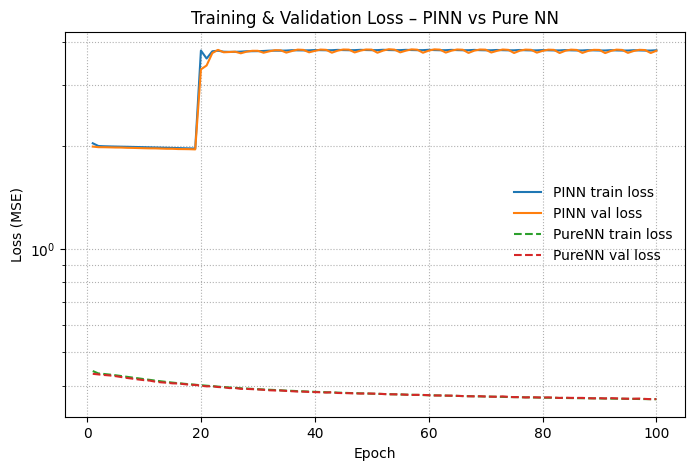

In [ ]:
plt.figure(figsize=(8,5))

# PINN train & val
plt.plot(history_pinn["epoch"], history_pinn["train_loss"], label="PINN train loss")
plt.plot(history_pinn["epoch"], history_pinn["val_loss"],   label="PINN val loss")

# Pure NN train & val
plt.plot(history_pure["epoch"], history_pure["train_loss"], label="PureNN train loss", linestyle="--")
plt.plot(history_pure["epoch"], history_pure["val_loss"],   label="PureNN val loss",   linestyle="--")

plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss – PINN vs Pure NN")
plt.grid(True, which="both", ls=":")
plt.legend(frameon=False)
plt.show()


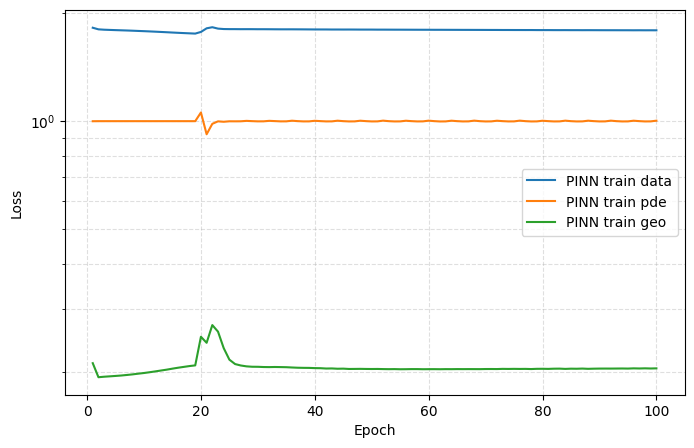

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history_pinn["epoch"], history_pinn["train_data"], label="PINN train data")
plt.plot(history_pinn["epoch"], history_pinn["train_pde"],  label="PINN train pde")
plt.plot(history_pinn["epoch"], history_pinn["train_geo"],  label="PINN train geo")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.show()


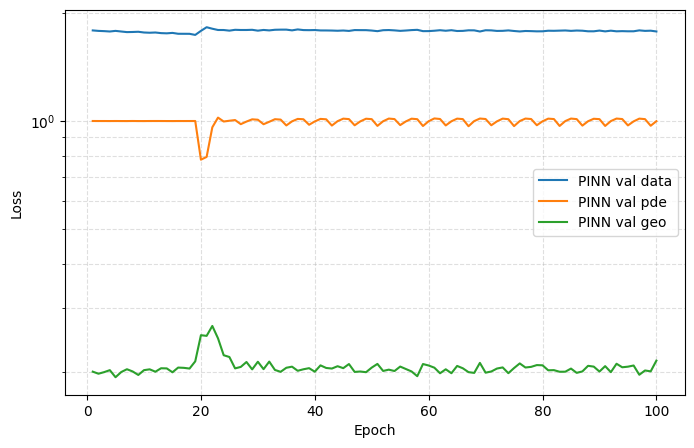

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history_pinn["epoch"], history_pinn["val_data"], label="PINN val data")
plt.plot(history_pinn["epoch"], history_pinn["val_pde"],  label="PINN val pde")
plt.plot(history_pinn["epoch"], history_pinn["val_geo"],  label="PINN val geo")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.show()


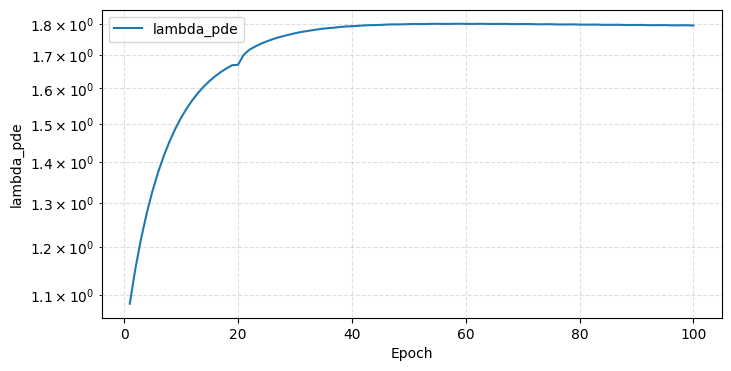

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history_pinn["epoch"], history_pinn["lambda_pde"], label="lambda_pde")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("lambda_pde")
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.legend()
plt.show()


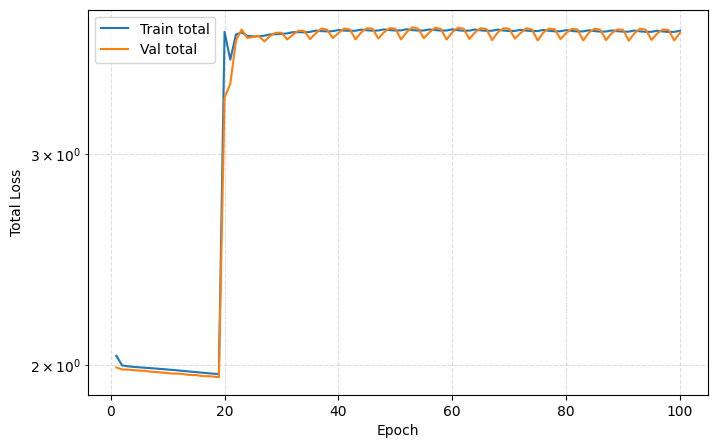

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history_pinn["epoch"], history_pinn["train_loss"], label="Train total")
plt.plot(history_pinn["epoch"], history_pinn["val_loss"],   label="Val total")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.show()


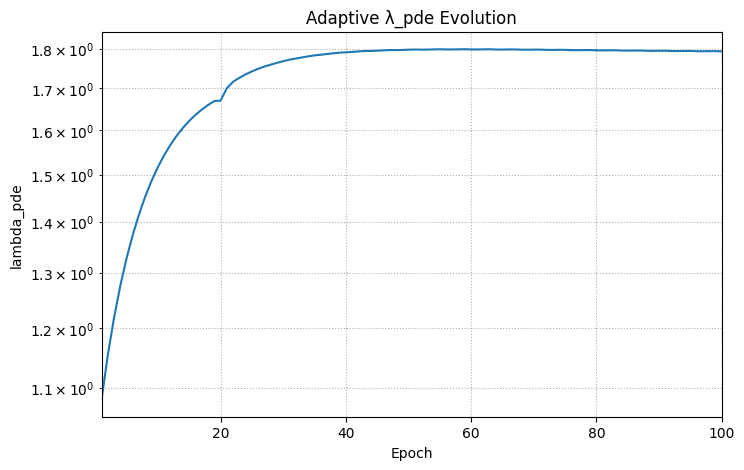

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history_pinn["epoch"], history_pinn["lambda_pde"])
plt.xlim(min(history_pinn["epoch"]), max(history_pinn["epoch"]))
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("lambda_pde")
plt.title("Adaptive λ_pde Evolution")
plt.grid(True, which="both", ls=":")
plt.show()


Δphi stats (wrapped): mean/std = 0.004330026236827722 0.9521175937628831
Δeta stats:           mean/std = -0.15711072948015573 1.1945944612677195


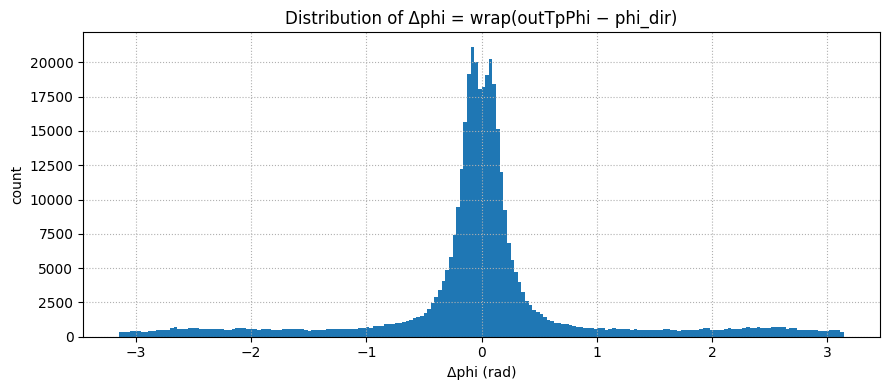

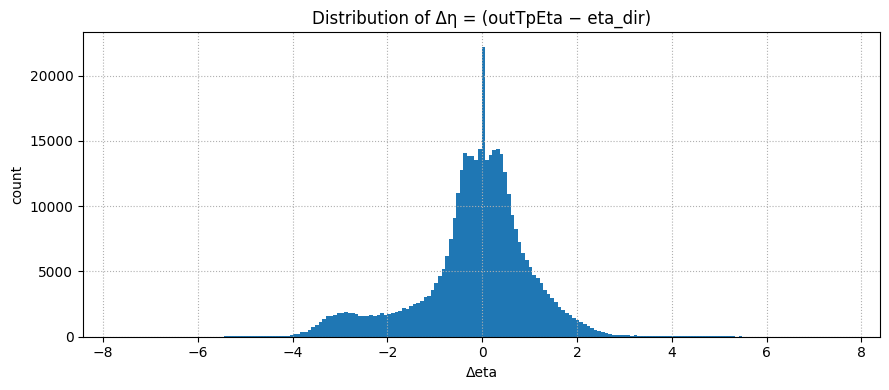

⚠️ Label kolonu var (label) ama 0/1 ayrımı yok gibi görünüyor. unique: [-1  1]


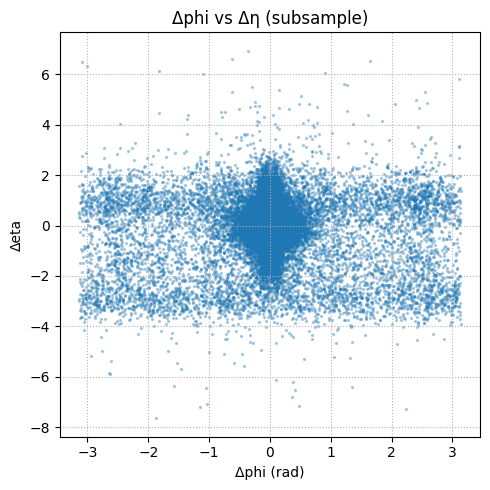

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------
# Helpers
# -----------------------
def wrap_phi(dphi):
    return (dphi + np.pi) % (2*np.pi) - np.pi

def compute_phi_eta_dir(df, eps=1e-12):
    dx = df["outX"].to_numpy() - df["inX"].to_numpy()
    dy = df["outY"].to_numpy() - df["inY"].to_numpy()
    dz = df["outZ"].to_numpy() - df["inZ"].to_numpy()
    dr = np.sqrt(dx*dx + dy*dy) + eps

    phi_dir = np.arctan2(dy, dx)
    eta_dir = np.arcsinh(dz / dr)
    return phi_dir, eta_dir

# -----------------------
# Sample for fast plotting
# -----------------------
dfp = data_sample.sample(n=min(400_000, len(data_sample)), random_state=42).copy()

phi_dir, eta_dir = compute_phi_eta_dir(dfp)

phi_true = dfp["outTpPhi"].to_numpy()
eta_true = dfp["outTpEta"].to_numpy()

dphi = wrap_phi(phi_true - phi_dir)
deta = eta_true - eta_dir

print("Δphi stats (wrapped): mean/std =", float(dphi.mean()), float(dphi.std()))
print("Δeta stats:           mean/std =", float(deta.mean()), float(deta.std()))

# -----------------------
# 1) Overall histograms
# -----------------------
plt.figure(figsize=(9,4))
plt.hist(dphi, bins=200)
plt.title("Distribution of Δphi = wrap(outTpPhi − phi_dir)")
plt.xlabel("Δphi (rad)")
plt.ylabel("count")
plt.grid(True, ls=":")
plt.tight_layout()
plt.show()

plt.figure(figsize=(9,4))
plt.hist(deta, bins=200)
plt.title("Distribution of Δη = (outTpEta − eta_dir)")
plt.xlabel("Δeta")
plt.ylabel("count")
plt.grid(True, ls=":")
plt.tight_layout()
plt.show()

# -----------------------
# 2) If label exists: genuine vs fake
# -----------------------
label_col = None
for c in ["label", "Label", "isGenuine", "is_true", "y", "target"]:
    if c in dfp.columns:
        label_col = c
        break

if label_col is None:
    print("⚠️ Label kolonu bulunamadı. (genuine/fake ayrımı yapmadan sadece overall histogram çizildi.)")
else:
    y = dfp[label_col].to_numpy()
    # label convention unknown -> try both: 1 genuine, 0 fake (common)
    m1 = (y == 1)
    m0 = (y == 0)

    if m1.sum() == 0 or m0.sum() == 0:
        print(f"⚠️ Label kolonu var ({label_col}) ama 0/1 ayrımı yok gibi görünüyor. unique:", np.unique(y)[:10])
    else:
        plt.figure(figsize=(9,4))
        plt.hist(dphi[m1], bins=200, alpha=0.6, label="label=1")
        plt.hist(dphi[m0], bins=200, alpha=0.6, label="label=0")
        plt.title(f"Δphi by label ({label_col})")
        plt.xlabel("Δphi (rad)")
        plt.ylabel("count")
        plt.grid(True, ls=":")
        plt.legend()
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(9,4))
        plt.hist(deta[m1], bins=200, alpha=0.6, label="label=1")
        plt.hist(deta[m0], bins=200, alpha=0.6, label="label=0")
        plt.title(f"Δeta by label ({label_col})")
        plt.xlabel("Δeta")
        plt.ylabel("count")
        plt.grid(True, ls=":")
        plt.legend()
        plt.tight_layout()
        plt.show()

# -----------------------
# 3) Scatter quick check (optional)
# -----------------------
n_sc = min(30_000, len(dfp))
idx = np.random.choice(len(dfp), size=n_sc, replace=False)
plt.figure(figsize=(5,5))
plt.scatter(dphi[idx], deta[idx], s=2, alpha=0.3)
plt.title("Δphi vs Δη (subsample)")
plt.xlabel("Δphi (rad)")
plt.ylabel("Δeta")
plt.grid(True, ls=":")
plt.tight_layout()
plt.show()


✅ GIF kaydedildi: training_pinn_vs_pure_phi.gif


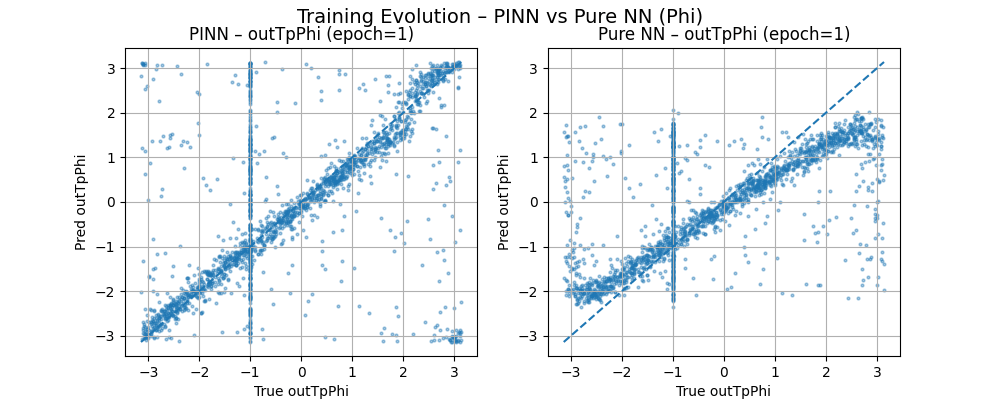

In [ ]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

num_frames = min(len(snapshots_pinn), len(snapshots_pure))

if num_frames == 0:
    print("⚠️ Hiç snapshot toplanmamış, GIF oluşturulamıyor. "
          "PINN ve Pure NN eğitim döngülerindeki SNAPSHOT bloklarını kontrol et.")
else:
    y_true_phi = y_anim_true[:, 0]  # gerçek Phi

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    def init():
        for ax, title in zip(axes, ["PINN", "Pure NN"]):
            ax.set_xlabel("True outTpPhi")
            ax.set_ylabel("Predicted outTpPhi")
            ax.grid(True)
            ax.plot(
                [y_true_phi.min(), y_true_phi.max()],
                [y_true_phi.min(), y_true_phi.max()],
                linestyle="--"
            )
        return axes

    def update(frame_idx):
        epoch_pinn, y_pinn = snapshots_pinn[frame_idx]
        epoch_pure, y_pure = snapshots_pure[frame_idx]

        y_pinn_phi = y_pinn[:, 0]
        y_pure_phi = y_pure[:, 0]

        for ax in axes:
            ax.cla()

        # PINN
        axes[0].scatter(y_true_phi, y_pinn_phi, s=4, alpha=0.4)
        axes[0].plot(
            [y_true_phi.min(), y_true_phi.max()],
            [y_true_phi.min(), y_true_phi.max()],
            "--"
        )
        axes[0].set_title(f"PINN – outTpPhi (epoch={epoch_pinn})")
        axes[0].set_xlabel("True outTpPhi")
        axes[0].set_ylabel("Pred outTpPhi")
        axes[0].grid(True)

        # Pure NN
        axes[1].scatter(y_true_phi, y_pure_phi, s=4, alpha=0.4)
        axes[1].plot(
            [y_true_phi.min(), y_true_phi.max()],
            [y_true_phi.min(), y_true_phi.max()],
            "--"
        )
        axes[1].set_title(f"Pure NN – outTpPhi (epoch={epoch_pure})")
        axes[1].set_xlabel("True outTpPhi")
        axes[1].set_ylabel("Pred outTpPhi")
        axes[1].grid(True)

        fig.suptitle("Training Evolution – PINN vs Pure NN (Phi)", fontsize=14)
        return axes

    anim = FuncAnimation(
        fig, update,
        frames=num_frames,
        init_func=init,
        blit=False
    )

    gif_writer = PillowWriter(fps=5)
    anim.save("training_pinn_vs_pure_phi.gif", writer=gif_writer)
    plt.close(fig)
    print("✅ GIF kaydedildi: training_pinn_vs_pure_phi.gif")

from IPython.display import Image
Image(filename="training_pinn_vs_pure_phi.gif")


## 6. Model Sonuçları
PINN ve NN için MSE, MAE, R² karşılaştırması.


In [ ]:
# =========================
# 6. Test Set Üzerinde Değerlendirme
# =========================

model.eval()
with torch.no_grad():
    u_test = model(X_test)             # [N_test, 6]
    Px = u_test[:, 3]
    Py = u_test[:, 4]
    Pz = u_test[:, 5]
    phi_test, eta_test = mom_to_phi_eta(Px, Py, Pz)
    y_pred_pinn = torch.stack([phi_test, eta_test], dim=1).cpu().numpy()


pure_model.eval()
with torch.no_grad():
    y_pred_pure_norm = pure_model(X_test).cpu().numpy()
y_pred_pure = y_pred_pure_norm * y_std + y_mean

def metrics(y_true, y_pred):
    return {
        "Phi_MSE": mean_squared_error(y_true[:,0], y_pred[:,0]),
        "Phi_MAE": mean_absolute_error(y_true[:,0], y_pred[:,0]),
        "Phi_R2":  r2_score(y_true[:,0], y_pred[:,0]),
        "Eta_MSE": mean_squared_error(y_true[:,1], y_pred[:,1]),
        "Eta_MAE": mean_absolute_error(y_true[:,1], y_pred[:,1]),
        "Eta_R2":  r2_score(y_true[:,1], y_pred[:,1]),
    }

metrics_pinn = metrics(y_true_test, y_pred_pinn)
metrics_pure = metrics(y_true_test, y_pred_pure)

df_metrics = pd.DataFrame([metrics_pinn, metrics_pure], index=["PINN", "Pure NN"])
print("Test set metrics:")
print(df_metrics)



Test set metrics:
          Phi_MSE   Phi_MAE    Phi_R2   Eta_MSE   Eta_MAE    Eta_R2
PINN     2.344953  0.793474  0.197837  0.950757  0.647501  0.574108
Pure NN  1.185194  0.743197  0.594568  0.729895  0.608807  0.673043


## 7. Scatter ve Fit
Gerçek vs tahmin grafikleri + fit çizgisi + ±σ bantları.


In [ ]:
from sklearn.linear_model import LinearRegression

def fit_line(y_true, y_pred):
    model = LinearRegression()
    model.fit(y_true.reshape(-1,1), y_pred.reshape(-1,1))
    a = model.coef_[0][0]
    b = model.intercept_[0]
    return a, b


In [ ]:
def plot_with_fit_and_band(y_true, y_pred, title=""):
    idx = np.argsort(y_true)
    yt = y_true[idx]
    yp = y_pred[idx]

    a, b = fit_line(yt, yp)
    yp_fit = a*yt + b

    residuals = yp - yp_fit
    sigma = residuals.std()

    upper_1, lower_1 = yp_fit + sigma, yp_fit - sigma
    upper_2, lower_2 = yp_fit + 2*sigma, yp_fit - 2*sigma

    plt.figure(figsize=(7,6))
    plt.scatter(yt, yp, s=2, alpha=0.3)
    plt.plot(yt, yp_fit, 'r-', linewidth=2, label=f"Fit: y={a:.2f}x+{b:.2f}")
    plt.fill_between(yt, lower_1, upper_1, color='orange', alpha=0.25, label="±1σ")
    plt.fill_between(yt, lower_2, upper_2, color='orange', alpha=0.12, label="±2σ")
    plt.plot(yt, yt, 'k--', label="y=x")
    plt.title(title)
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.legend()
    plt.grid(True)
    plt.show()


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


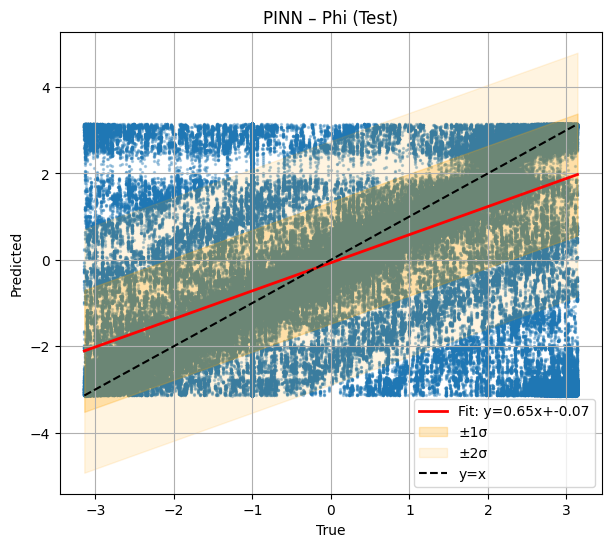

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


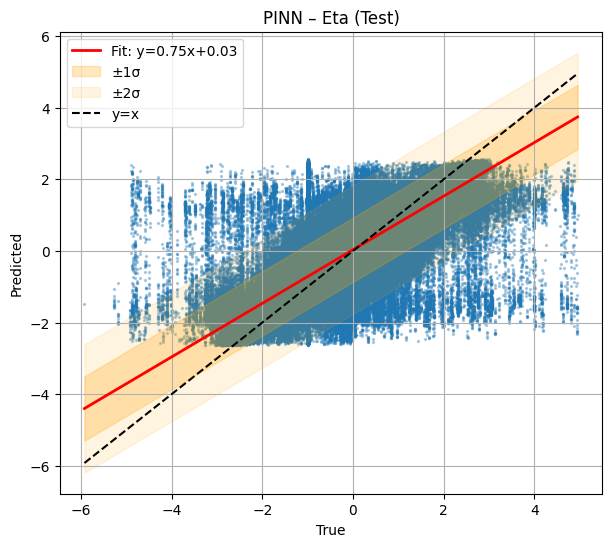

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


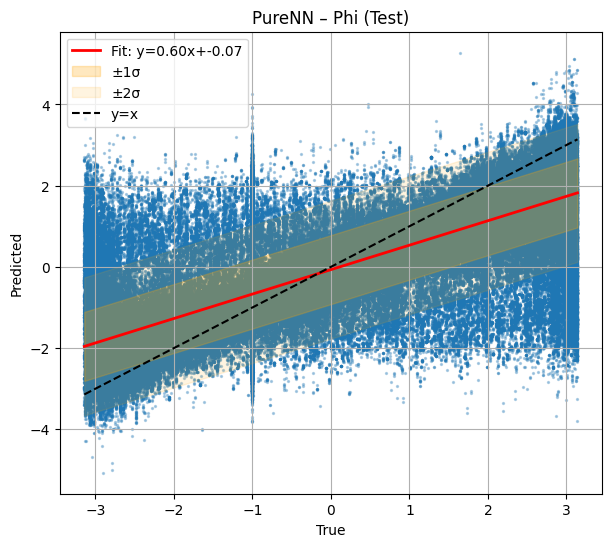

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


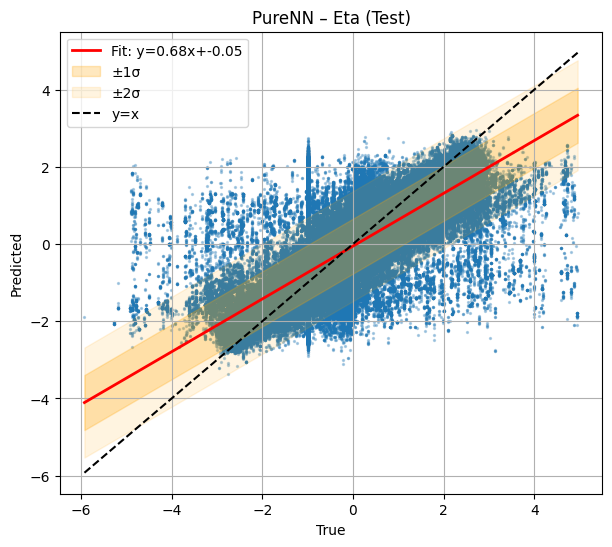

In [ ]:
# PINN – Test set
plot_with_fit_and_band(y_true_test[:, 0], y_pred_pinn[:, 0], title="PINN – Phi (Test)")
plot_with_fit_and_band(y_true_test[:, 1], y_pred_pinn[:, 1], title="PINN – Eta (Test)")

# Pure NN – Test set
plot_with_fit_and_band(y_true_test[:, 0], y_pred_pure[:, 0], title="PureNN – Phi (Test)")
plot_with_fit_and_band(y_true_test[:, 1], y_pred_pure[:, 1], title="PureNN – Eta (Test)")



In [ ]:
def plot_delta(y_true, y_pred_pinn, y_pred_pure, title=""):
    delta = y_pred_pinn - y_pred_pure  # PINN - NN farkı

    plt.figure(figsize=(7,5))
    plt.scatter(y_true, delta, s=3, alpha=0.4)
    plt.axhline(0, color='k', linestyle='--', linewidth=1)

    plt.xlabel("True Value")
    plt.ylabel("PINN - PureNN Prediction Difference")
    plt.title(f"Model Difference (PINN - PureNN): {title}")
    plt.grid(True)
    plt.show()


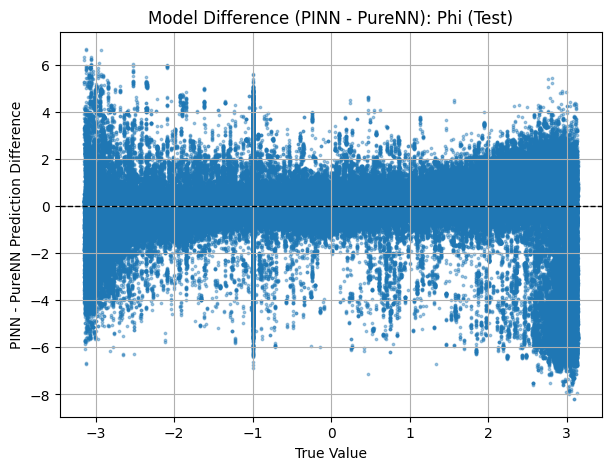

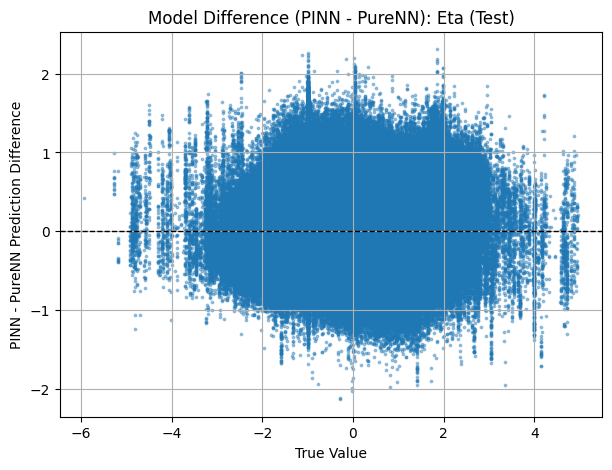

In [ ]:
plot_delta(y_true_test[:, 0], y_pred_pinn[:, 0], y_pred_pure[:, 0], "Phi (Test)")
plot_delta(y_true_test[:, 1], y_pred_pinn[:, 1], y_pred_pure[:, 1], "Eta (Test)")


## 8. Hata Dağılımı
Modellerin hata histogramları karşılaştırılır.


In [ ]:
def plot_error_hist(y_true, y_pinn, y_pure, title=""):
    err_pinn = y_pinn - y_true
    err_pure = y_pure - y_true

    plt.figure(figsize=(7,5))

    plt.hist(err_pinn, bins=50, alpha=0.5, label="PINN Error")
    plt.hist(err_pure, bins=50, alpha=0.5, label="Pure NN Error")

    plt.xlabel("Prediction Error")
    plt.ylabel("Frequency")
    plt.title(f"Error Distribution: {title}")
    plt.legend()
    plt.grid(True)
    plt.show()


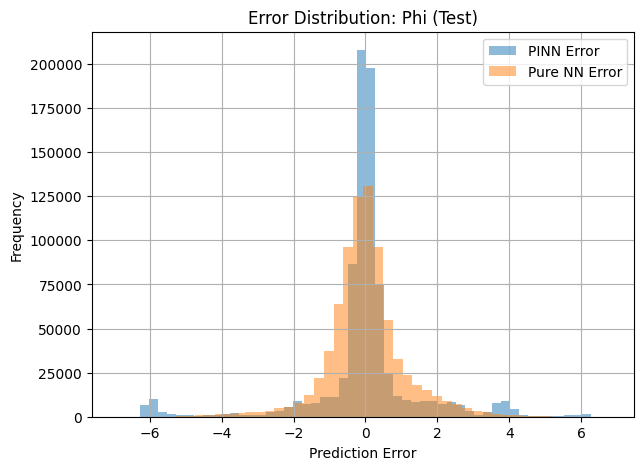

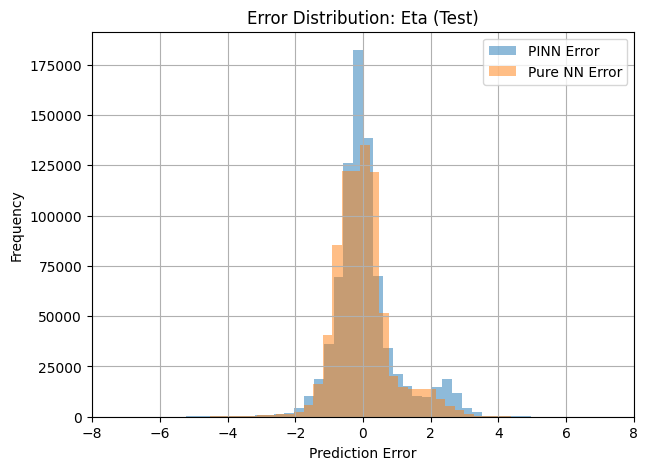

In [ ]:
# Test set üzerindeki hata histogramları
plot_error_hist(y_true_test[:, 0], y_pred_pinn[:, 0], y_pred_pure[:, 0], "Phi (Test)")
plot_error_hist(y_true_test[:, 1], y_pred_pinn[:, 1], y_pred_pure[:, 1], "Eta (Test)")


In [ ]:
def plot_scatter_compare(y_true, y_pinn, y_pure, title=""):

    idx = np.argsort(y_true)
    yt = y_true[idx]
    yp_pinn = y_pinn[idx]
    yp_pure = y_pure[idx]

    fig, axes = plt.subplots(2, 1, figsize=(7,10))

    # --- PINN ---
    axes[0].scatter(yt, yp_pinn, s=2, alpha=0.4)
    axes[0].plot(yt, yt, 'k--')
    axes[0].set_title(f"PINN Prediction: {title}")
    axes[0].set_xlabel("True")
    axes[0].set_ylabel("Predicted")
    axes[0].grid(True)

    # --- Pure NN ---
    axes[1].scatter(yt, yp_pure, s=2, alpha=0.4)
    axes[1].plot(yt, yt, 'k--')
    axes[1].set_title(f"Pure NN Prediction: {title}")
    axes[1].set_xlabel("True")
    axes[1].set_ylabel("Predicted")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


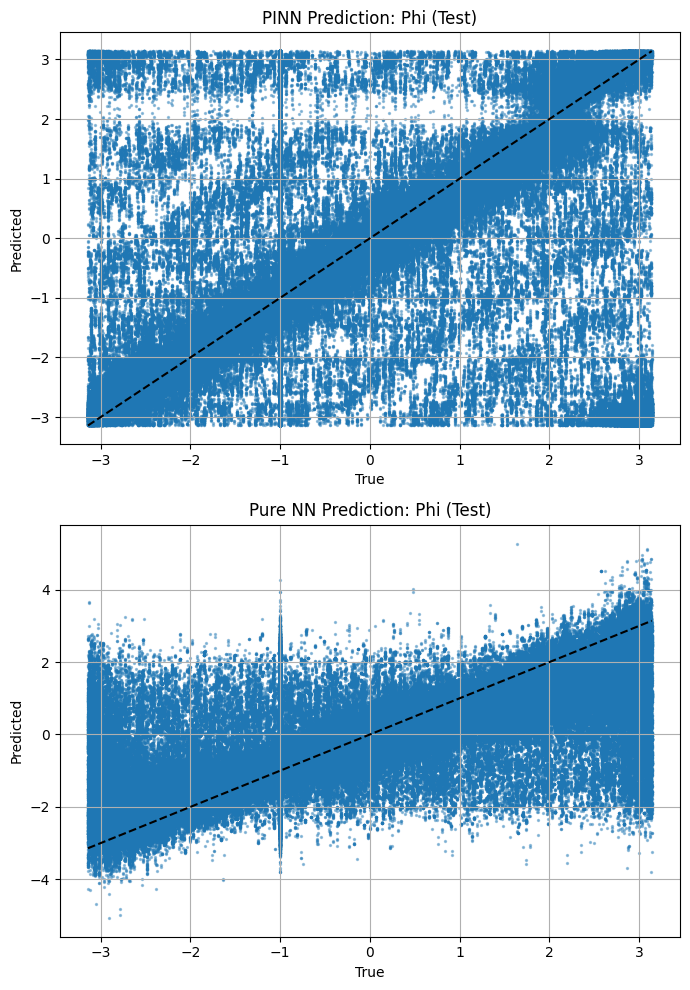

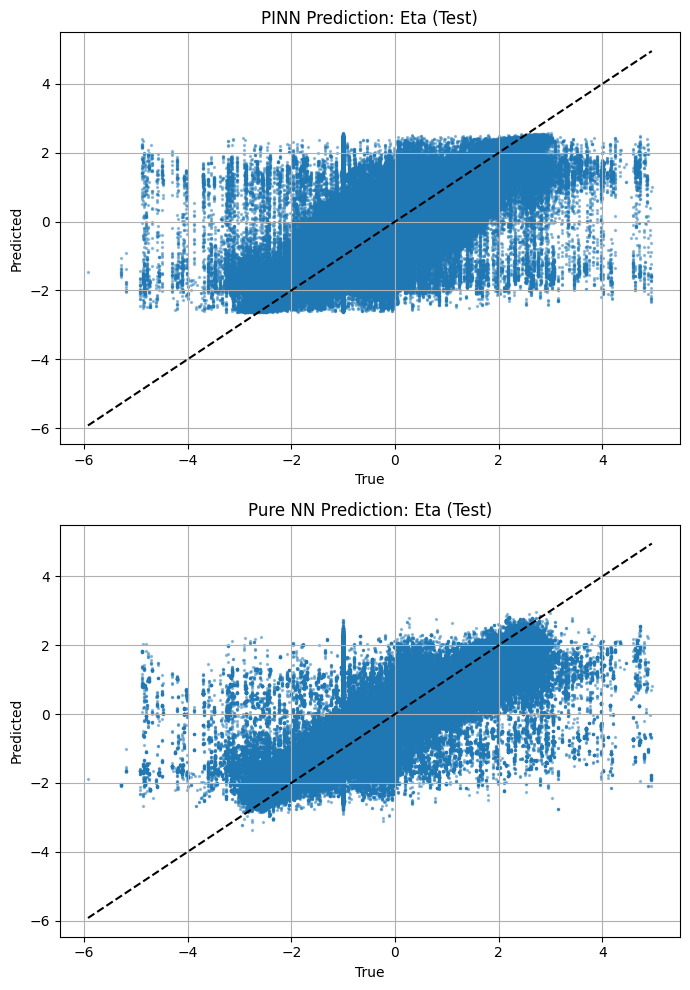

In [ ]:
plot_scatter_compare(y_true_test[:, 0], y_pred_pinn[:, 0], y_pred_pure[:, 0], "Phi (Test)")
plot_scatter_compare(y_true_test[:, 1], y_pred_pinn[:, 1], y_pred_pure[:, 1], "Eta (Test)")


## 9. PINN – NN Görsel Karşılaştırması
Aşağıdaki görsellerde PINN ve NN sonuçları daha net ve anlaşılır şekilde karşılaştırılmaktadır.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

def set_paper_style():
    plt.rcParams.update({
        "figure.figsize": (7, 6),
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "font.size": 12,
        "font.family": "serif",
        "axes.labelsize": 12,
        "axes.titlesize": 13,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "legend.fontsize": 11,
        "axes.linewidth": 1.0,
        "lines.linewidth": 1.5,
        "grid.alpha": 0.3,
    })


In [ ]:
set_paper_style()


In [ ]:
def compute_fit_and_bands(y_true, y_pred):
    # x'e göre sırala (grafiğin düzgün görünmesi için)
    idx = np.argsort(y_true)
    yt = y_true[idx]
    yp = y_pred[idx]

    # Lineer fit: y_pred ≈ a * y_true + b
    reg = LinearRegression()
    reg.fit(yt.reshape(-1, 1), yp.reshape(-1, 1))
    a = reg.coef_[0, 0]
    b = reg.intercept_[0]
    yp_fit = a * yt + b

    residuals = yp - yp_fit
    sigma = residuals.std()

    band1_upper = yp_fit + sigma
    band1_lower = yp_fit - sigma
    band2_upper = yp_fit + 2 * sigma
    band2_lower = yp_fit - 2 * sigma

    return yt, yp, yp_fit, band1_lower, band1_upper, band2_lower, band2_upper, a, b, sigma


In [ ]:
def plot_pinn_vs_nn_scatter_with_bands(
    y_true_phi, y_pinn_phi, y_pure_phi,
    y_true_eta, y_pinn_eta, y_pure_eta
):
    set_paper_style()

    fig, axes = plt.subplots(2, 2, figsize=(10, 9), constrained_layout=True)

    # --- ÜST SOL: Phi – PINN ---
    yt, yp, yp_fit, b1_l, b1_u, b2_l, b2_u, a, b, sigma = compute_fit_and_bands(
        y_true_phi, y_pinn_phi
    )
    ax = axes[0, 0]
    ax.scatter(yt, yp, s=4, alpha=0.4)
    ax.plot(yt, yp_fit)
    ax.fill_between(yt, b1_l, b1_u, alpha=0.25, label="±1σ band")
    ax.fill_between(yt, b2_l, b2_u, alpha=0.12, label="±2σ band")
    ax.plot(yt, yt, linestyle="--", linewidth=1.0, label="y = x (ideal)")
    ax.set_title("PINN – outTpPhi")
    ax.set_xlabel("True outTpPhi")
    ax.set_ylabel("Predicted outTpPhi")
    ax.grid(True)
    ax.legend(frameon=False)

    # --- ÜST SAĞ: Phi – Pure NN ---
    yt, yp, yp_fit, b1_l, b1_u, b2_l, b2_u, a, b, sigma = compute_fit_and_bands(
        y_true_phi, y_pure_phi
    )
    ax = axes[0, 1]
    ax.scatter(yt, yp, s=4, alpha=0.4)
    ax.plot(yt, yp_fit)
    ax.fill_between(yt, b1_l, b1_u, alpha=0.25, label="±1σ band")
    ax.fill_between(yt, b2_l, b2_u, alpha=0.12, label="±2σ band")
    ax.plot(yt, yt, linestyle="--", linewidth=1.0, label="y = x (ideal)")
    ax.set_title("Pure NN – outTpPhi")
    ax.set_xlabel("True outTpPhi")
    ax.set_ylabel("Predicted outTpPhi")
    ax.grid(True)
    ax.legend(frameon=False)

    # --- ALT SOL: Eta – PINN ---
    yt, yp, yp_fit, b1_l, b1_u, b2_l, b2_u, a, b, sigma = compute_fit_and_bands(
        y_true_eta, y_pinn_eta
    )
    ax = axes[1, 0]
    ax.scatter(yt, yp, s=4, alpha=0.4)
    ax.plot(yt, yp_fit)
    ax.fill_between(yt, b1_l, b1_u, alpha=0.25, label="±1σ band")
    ax.fill_between(yt, b2_l, b2_u, alpha=0.12, label="±2σ band")
    ax.plot(yt, yt, linestyle="--", linewidth=1.0, label="y = x (ideal)")
    ax.set_title("PINN – outTpEta")
    ax.set_xlabel("True outTpEta")
    ax.set_ylabel("Predicted outTpEta")
    ax.grid(True)
    ax.legend(frameon=False)

    # --- ALT SAĞ: Eta – Pure NN ---
    yt, yp, yp_fit, b1_l, b1_u, b2_l, b2_u, a, b, sigma = compute_fit_and_bands(
        y_true_eta, y_pure_eta
    )
    ax = axes[1, 1]
    ax.scatter(yt, yp, s=4, alpha=0.4)
    ax.plot(yt, yp_fit)
    ax.fill_between(yt, b1_l, b1_u, alpha=0.25, label="±1σ band")
    ax.fill_between(yt, b2_l, b2_u, alpha=0.12, label="±2σ band")
    ax.plot(yt, yt, linestyle="--", linewidth=1.0, label="y = x (ideal)")
    ax.set_title("Pure NN – outTpEta")
    ax.set_xlabel("True outTpEta")
    ax.set_ylabel("Predicted outTpEta")
    ax.grid(True)
    ax.legend(frameon=False)

    fig.suptitle("PINN vs Pure NN – True vs Predicted with Fit and Uncertainty Bands", fontsize=14)
    plt.show()


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


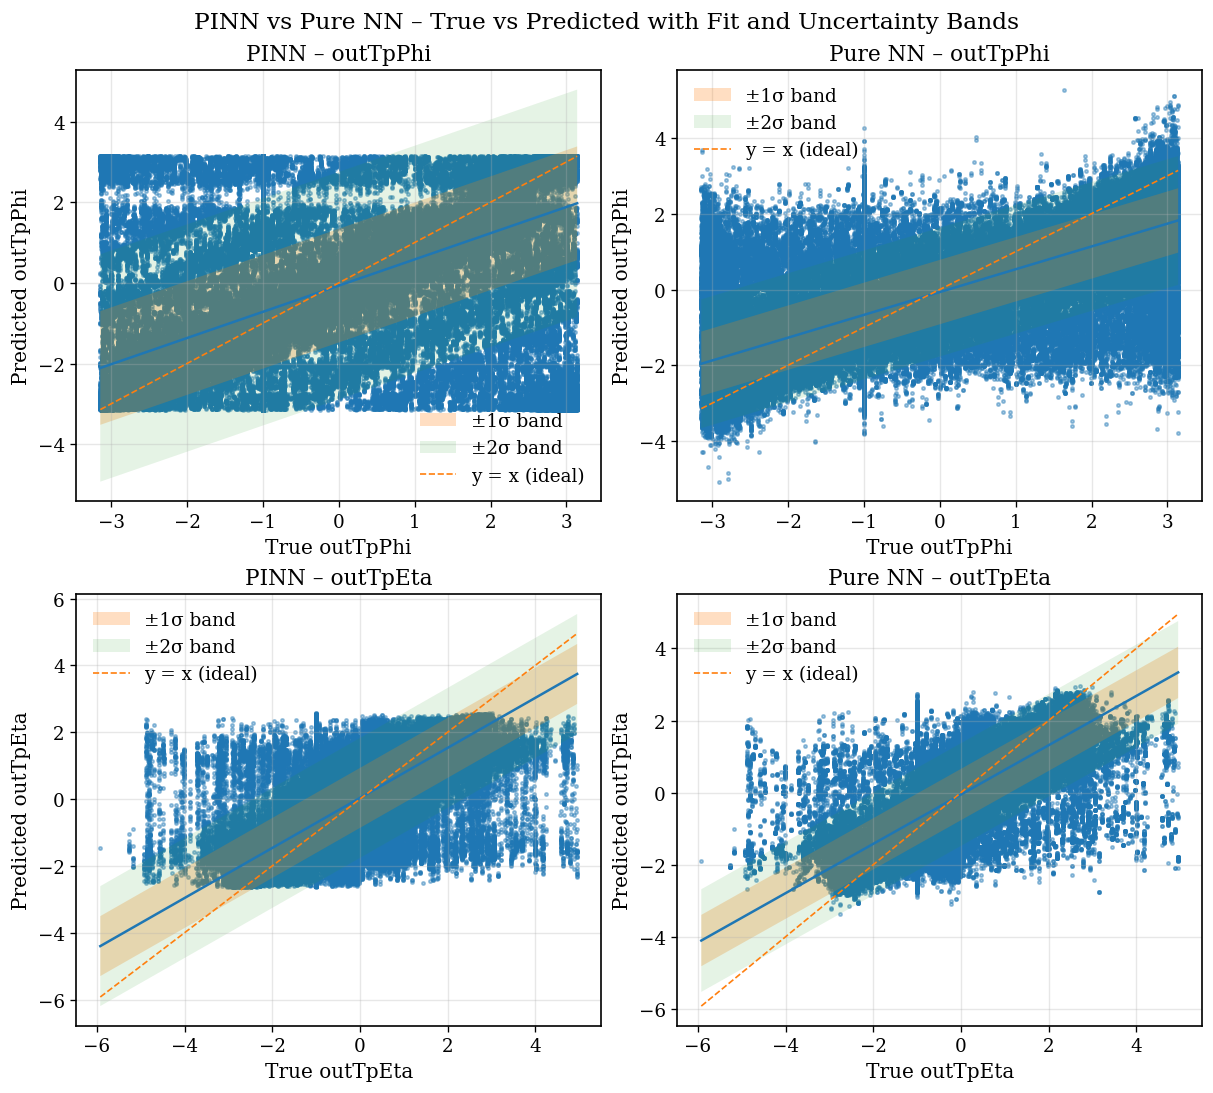

In [ ]:
plot_pinn_vs_nn_scatter_with_bands(
    y_true_test[:, 0],  # true Phi (TEST)
    y_pred_pinn[:, 0],
    y_pred_pure[:, 0],
    y_true_test[:, 1],  # true Eta (TEST)
    y_pred_pinn[:, 1],
    y_pred_pure[:, 1],
)



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def set_paper_style():
    plt.rcParams.update({
        "figure.figsize": (7, 6),
        "figure.dpi": 120,
        "savefig.dpi": 300,
        "font.size": 12,
        "font.family": "serif",
        "axes.labelsize": 12,
        "axes.titlesize": 13,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "legend.fontsize": 11,
        "axes.linewidth": 1.0,
        "lines.linewidth": 1.5,
        "grid.alpha": 0.3,
    })


In [ ]:
set_paper_style()


In [ ]:
def plot_error_hist_one(y_true, y_pinn, y_pure, title=""):
    err_pinn = y_pinn - y_true
    err_pure = y_pure - y_true

    # Ortak bin aralığı seç (her iki dağılımı kapsasın)
    all_err = np.concatenate([err_pinn, err_pure])
    err_min, err_max = np.percentile(all_err, [1, 99])  # uç outlier’ları biraz kes
    bins = np.linspace(err_min, err_max, 50)

    plt.figure(figsize=(7, 5))
    plt.hist(err_pinn, bins=bins, density=True, alpha=0.5,
             label="PINN error", edgecolor="black", linewidth=0.5)
    plt.hist(err_pure, bins=bins, density=True, alpha=0.5,
             label="Pure NN error", edgecolor="black", linewidth=0.5)

    plt.axvline(0.0, color="k", linestyle="--", linewidth=1.0)
    plt.xlabel("Prediction error (y_pred − y_true)")
    plt.ylabel("Density")
    plt.title(title)
    plt.legend(frameon=False)
    plt.grid(True)
    plt.show()


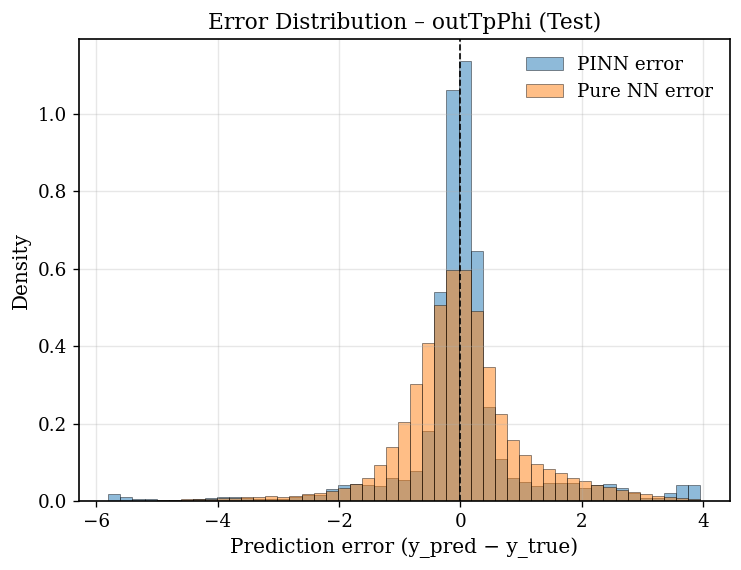

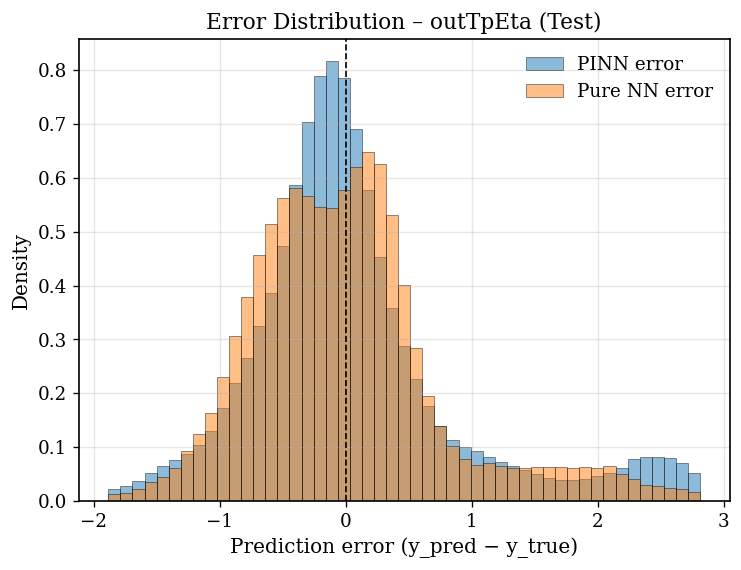

In [ ]:
# Phi (Test)
plot_error_hist_one(
    y_true_test[:,0], y_pred_pinn[:,0], y_pred_pure[:,0],
    title="Error Distribution – outTpPhi (Test)"
)

# Eta (Test)
plot_error_hist_one(
    y_true_test[:,1], y_pred_pinn[:,1], y_pred_pure[:,1],
    title="Error Distribution – outTpEta (Test)"
)


In [ ]:
def plot_error_hist_phi_eta(
    y_true_phi, y_pinn_phi, y_pure_phi,
    y_true_eta, y_pinn_eta, y_pure_eta
):
    set_paper_style()

    # --- Phi ---
    err_pinn_phi = y_pinn_phi - y_true_phi
    err_pure_phi = y_pure_phi - y_true_phi

    all_err_phi = np.concatenate([err_pinn_phi, err_pure_phi])
    phi_min, phi_max = np.percentile(all_err_phi, [1, 99])
    bins_phi = np.linspace(phi_min, phi_max, 50)

    # --- Eta ---
    err_pinn_eta = y_pinn_eta - y_true_eta
    err_pure_eta = y_pure_eta - y_true_eta

    all_err_eta = np.concatenate([err_pinn_eta, err_pure_eta])
    eta_min, eta_max = np.percentile(all_err_eta, [1, 99])
    bins_eta = np.linspace(eta_min, eta_max, 50)

    fig, axes = plt.subplots(2, 1, figsize=(7, 8), constrained_layout=True)

    # Panel 1 – Phi
    ax = axes[0]
    ax.hist(err_pinn_phi, bins=bins_phi, density=True, alpha=0.5,
            label="PINN error", edgecolor="black", linewidth=0.5)
    ax.hist(err_pure_phi, bins=bins_phi, density=True, alpha=0.5,
            label="Pure NN error", edgecolor="black", linewidth=0.5)
    ax.axvline(0.0, color="k", linestyle="--", linewidth=1.0)
    ax.set_title("Error Distribution – outTpPhi")
    ax.set_xlabel("Prediction error (Phi)")
    ax.set_ylabel("Density")
    ax.legend(frameon=False)
    ax.grid(True)

    # Panel 2 – Eta
    ax = axes[1]
    ax.hist(err_pinn_eta, bins=bins_eta, density=True, alpha=0.5,
            label="PINN error", edgecolor="black", linewidth=0.5)
    ax.hist(err_pure_eta, bins=bins_eta, density=True, alpha=0.5,
            label="Pure NN error", edgecolor="black", linewidth=0.5)
    ax.axvline(0.0, color="k", linestyle="--", linewidth=1.0)
    ax.set_title("Error Distribution – outTpEta")
    ax.set_xlabel("Prediction error (Eta)")
    ax.set_ylabel("Density")
    ax.legend(frameon=False)
    ax.grid(True)

    fig.suptitle("PINN vs Pure NN – Error Distributions for outTpPhi and outTpEta",
                 fontsize=14)
    plt.show()


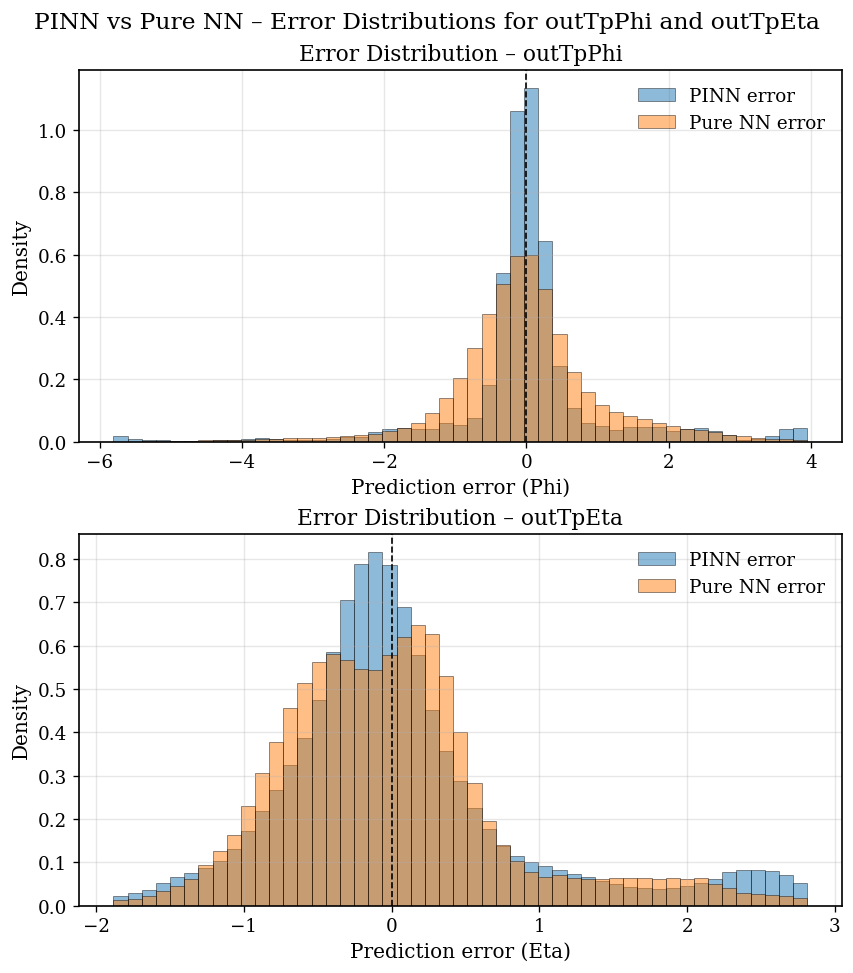

In [ ]:
plot_error_hist_phi_eta(
    y_true_test[:,0], y_pred_pinn[:,0], y_pred_pure[:,0],
    y_true_test[:,1], y_pred_pinn[:,1], y_pred_pure[:,1],
)


In [ ]:
hist_df = pd.DataFrame({
    "epoch":        history_pinn["epoch"],
    "train_loss":   history_pinn["train_loss"],
    "val_loss":     history_pinn["val_loss"],
    "train_data":   history_pinn["train_data"],
    "train_geo":    history_pinn["train_geo"],
    "train_pde":    history_pinn["train_pde"],
    "val_data":     history_pinn["val_data"],
    "val_geo":      history_pinn["val_geo"],
    "val_pde":      history_pinn["val_pde"],
    "lambda_pde":   history_pinn["lambda_pde"],
    "lambda_geo":   history_pinn["lambda_geo"],
})
hist_df.head()


epoch  train_loss  val_loss  train_data  train_geo  train_pde  val_data  \
0      1    2.033973  1.989397    1.822799   0.211174   0.999652  1.789520   
1      2    1.997052  1.981430    1.804110   0.192943   1.000013  1.784168   
2      3    1.993484  1.980697    1.799918   0.193566   1.000005  1.781426   
3      4    1.991452  1.979091    1.797411   0.194041   1.000026  1.777272   
4      5    1.989644  1.977135    1.795107   0.194537   1.000000  1.784270   

    val_geo   val_pde  lambda_pde  lambda_geo  
0  0.199878  1.000145    1.082343         1.0  
1  0.197262  0.999959    1.154518         1.0  
2  0.199271  0.999934    1.219057         1.0  
3  0.201819  0.999816    1.276888         1.0  
4  0.192865  1.000012    1.328710         1.0

In [ ]:
pure_hist_df = pd.DataFrame({
    "epoch":      history_pure["epoch"],
    "train_loss": history_pure["train_loss"],
    "val_loss":   history_pure["val_loss"],
})

print("=== Pure NN history (last 10 epochs) ===")
print(pure_hist_df.tail(10).to_string(index=False))

# İstersen CSV:
# pure_hist_df.to_csv("pure_history.csv", index=False)


=== Pure NN history (last 10 epochs) ===
 epoch  train_loss  val_loss
    91    0.366786  0.367087
    92    0.366585  0.367808
    93    0.366432  0.367236
    94    0.366233  0.366688
    95    0.366052  0.366411
    96    0.365921  0.366316
    97    0.365692  0.366755
    98    0.365495  0.365893
    99    0.365277  0.365285
   100    0.365139  0.365513


In [ ]:
from sklearn.metrics import r2_score

def fit_line_numeric(y_true, y_pred):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()

    # Lineer fit: y_pred ≈ a * y_true + b
    a, b = np.polyfit(y_true, y_pred, deg=1)
    r2 = r2_score(y_true, y_pred)

    return a, b, r2

results = []

# PINN – Phi
a, b, r2 = fit_line_numeric(y_true_test[:,0], y_pred_pinn[:,0])
results.append(["PINN", "Phi", a, b, r2])

# PINN – Eta
a, b, r2 = fit_line_numeric(y_true_test[:,1], y_pred_pinn[:,1])
results.append(["PINN", "Eta", a, b, r2])

# Pure – Phi
a, b, r2 = fit_line_numeric(y_true_test[:,0], y_pred_pure[:,0])
results.append(["Pure NN", "Phi", a, b, r2])

# Pure – Eta
a, b, r2 = fit_line_numeric(y_true_test[:,1], y_pred_pure[:,1])
results.append(["Pure NN", "Eta", a, b, r2])

fit_df = pd.DataFrame(results, columns=["Model", "Target", "slope_a", "intercept_b", "R2_again"])
print("=== Linear fit summary on TEST set ===")
print(fit_df.to_string(index=False))


=== Linear fit summary on TEST set ===
  Model Target  slope_a  intercept_b  R2_again
   PINN    Phi 0.649980    -0.067842  0.197837
   PINN    Eta 0.748611     0.033651  0.574108
Pure NN    Phi 0.601788    -0.067710  0.594568
Pure NN    Eta 0.683988    -0.054145  0.673043


In [ ]:
def error_stats(y_true, y_pred):
    err = np.asarray(y_pred).ravel() - np.asarray(y_true).ravel()
    return {
        "mean":   float(np.mean(err)),
        "std":    float(np.std(err)),
        "median": float(np.median(err)),
        "p05":    float(np.percentile(err, 5)),
        "p95":    float(np.percentile(err, 95)),
    }

rows = []

rows.append(["PINN",   "Phi", error_stats(y_true_test[:,0], y_pred_pinn[:,0])])
rows.append(["PINN",   "Eta", error_stats(y_true_test[:,1], y_pred_pinn[:,1])])
rows.append(["PureNN", "Phi", error_stats(y_true_test[:,0], y_pred_pure[:,0])])
rows.append(["PureNN", "Eta", error_stats(y_true_test[:,1], y_pred_pure[:,1])])

print("=== Error stats (Prediction - True) on TEST set ===")
for model, target, stats in rows:
    print(f"{model:6s} | {target:3s} | "
          f"mean={stats['mean']:.4f}, std={stats['std']:.4f}, "
          f"median={stats['median']:.4f}, p05={stats['p05']:.4f}, p95={stats['p95']:.4f}")


=== Error stats (Prediction - True) on TEST set ===
PINN   | Phi | mean=-0.0018, std=1.5313, median=0.0011, p05=-2.0970, p95=2.5466
PINN   | Eta | mean=0.0711, std=0.9725, median=-0.0740, p05=-1.1599, p95=2.3153
PureNN | Phi | mean=0.0075, std=1.0886, median=-0.0382, p05=-1.5633, p95=1.9531
PureNN | Eta | mean=-0.0071, std=0.8543, median=-0.0711, p05=-1.1014, p95=1.7533


In [ ]:
# =========================
# 10. Test seti için DataFrame: orijinal (denormalize) feature + hedef + tahmin
# =========================

# 1) Gerçekte kaç örnek kullandığını indekslerden bul
N_used = int(max(
    idx_train.max(),
    idx_val.max(),
    idx_test.max()
) + 1)

print("N_used (train/val/test toplam örnek):", N_used)

# 2) X_data'nın sadece bu kısmını al
X_data_used = X_data[:N_used]               # ilk N_used satır, split'lerle uyumlu

# 3) Test setine denk gelen orijinal feature'lar
X_test_orig = X_data_used[idx_test]         # shape: [N_test, len(feature_cols)]

df_test = pd.DataFrame(X_test_orig, columns=feature_cols)

# Gerçek (denormalize) hedefler
df_test["phi_true"] = y_true_test[:, 0]
df_test["eta_true"] = y_true_test[:, 1]

# PINN ve Pure NN tahminleri (denormalize)
df_test["phi_pinn"] = y_pred_pinn[:, 0]
df_test["eta_pinn"] = y_pred_pinn[:, 1]

df_test["phi_pure"] = y_pred_pure[:, 0]
df_test["eta_pure"] = y_pred_pure[:, 1]

# Hatalar
df_test["phi_err_pinn"] = df_test["phi_pinn"] - df_test["phi_true"]
df_test["phi_err_pure"] = df_test["phi_pure"] - df_test["phi_true"]
df_test["phi_abs_err_pinn"] = df_test["phi_err_pinn"].abs()
df_test["phi_abs_err_pure"] = df_test["phi_err_pure"].abs()

df_test["eta_err_pinn"] = df_test["eta_pinn"] - df_test["eta_true"]
df_test["eta_err_pure"] = df_test["eta_pure"] - df_test["eta_true"]
df_test["eta_abs_err_pinn"] = df_test["eta_err_pinn"].abs()
df_test["eta_abs_err_pure"] = df_test["eta_err_pure"].abs()

print(df_test.head())
print("Test set size:", len(df_test))


N_used (train/val/test toplam örnek): 5381062
       inX       inY        inZ      outX      outY       outZ    PU  \
0  2.86810   1.08675 -12.961600  12.13250   3.93047 -30.577000  48.0   
1  3.72706   5.85069  -8.477300   7.12294  11.53840 -31.764799  51.0   
2  1.36674 -10.41420  32.500401   1.78470 -13.56720  37.306000  56.0   
3 -3.25602 -11.00880  39.109600  -4.16864 -13.87890  48.642899  46.0   
4 -2.05911   2.26698  -3.154620  -4.71062   5.10489  19.546801  51.0   

   BunchCrossing  inTpCharge    inTpPt  ...  phi_pure  eta_pure  phi_err_pinn  \
0            0.0         1.0  1.192230  ... -0.034176 -1.414277      0.216443   
1            0.0         1.0  0.514739  ...  0.497038 -1.427304     -0.181538   
2           -1.0        -1.0 -1.000000  ... -1.400680  0.806669     -0.770453   
3            0.0         1.0  4.446820  ... -1.486192  1.108337     -0.009188   
4            0.0         1.0  0.210307  ...  0.872008  0.951361      0.525239   

   phi_err_pure  phi_abs_err_pinn 

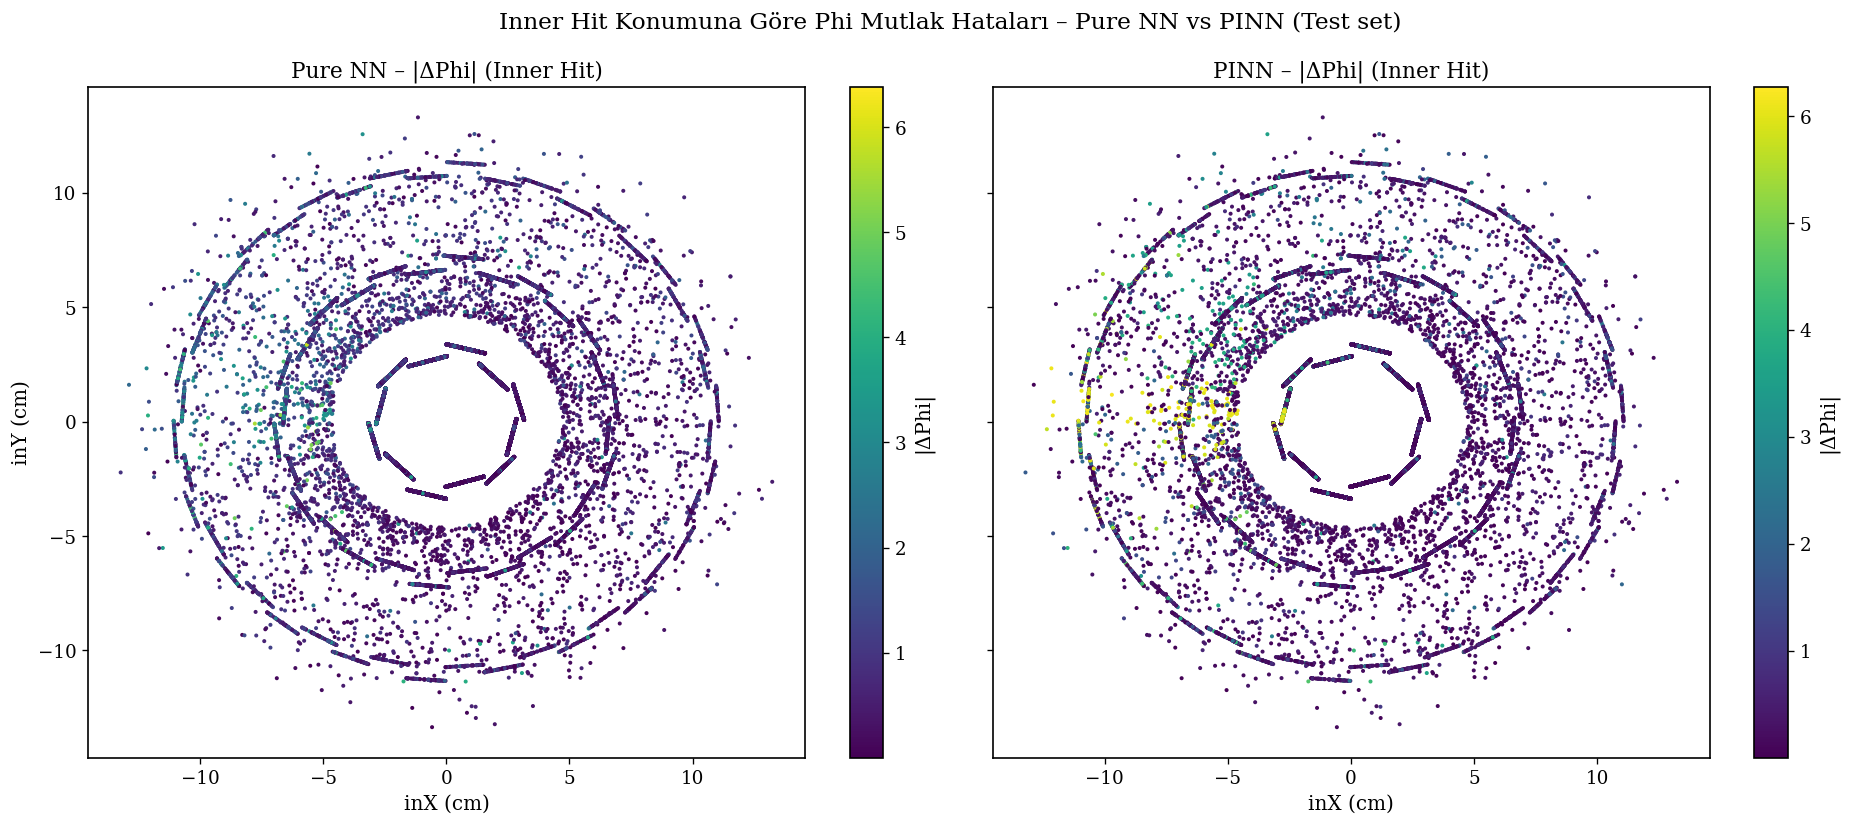

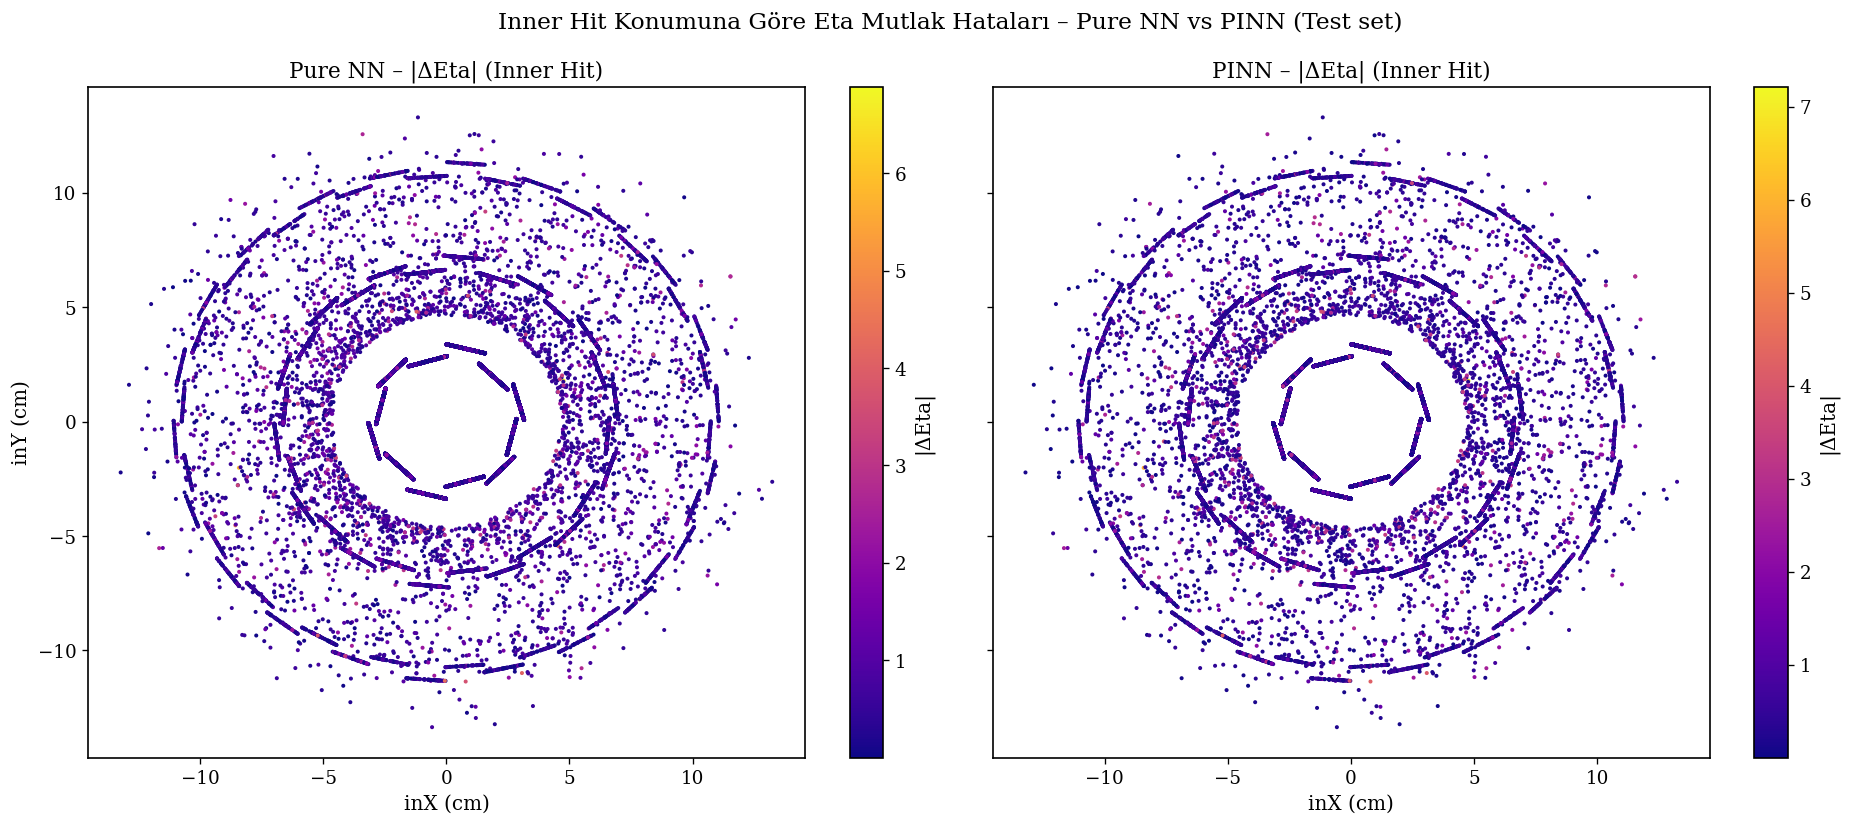

In [ ]:
import matplotlib.pyplot as plt

# Görselleştirme için örnek alt küme (test setten)
df_vis = df_test.sample(n=min(50_000, len(df_test)), random_state=42).copy()

# --- Phi için ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharex=True, sharey=True)

# Pure NN
sc1 = axes[0].scatter(
    df_vis["inX"], df_vis["inY"],
    c=df_vis["phi_abs_err_pure"],
    s=2,
    cmap="viridis"
)
axes[0].set_title("Pure NN – |ΔPhi| (Inner Hit)")
axes[0].set_xlabel("inX (cm)")
axes[0].set_ylabel("inY (cm)")
cbar1 = fig.colorbar(sc1, ax=axes[0])
cbar1.set_label("|ΔPhi|")

# PINN
sc2 = axes[1].scatter(
    df_vis["inX"], df_vis["inY"],
    c=df_vis["phi_abs_err_pinn"],
    s=2,
    cmap="viridis"
)
axes[1].set_title("PINN – |ΔPhi| (Inner Hit)")
axes[1].set_xlabel("inX (cm)")
cbar2 = fig.colorbar(sc2, ax=axes[1])
cbar2.set_label("|ΔPhi|")

plt.suptitle("Inner Hit Konumuna Göre Phi Mutlak Hataları – Pure NN vs PINN (Test set)", fontsize=14)
plt.tight_layout()
plt.show()

# --- Eta için ---
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharex=True, sharey=True)

sc1 = axes[0].scatter(
    df_vis["inX"], df_vis["inY"],
    c=df_vis["eta_abs_err_pure"],
    s=2,
    cmap="plasma"
)
axes[0].set_title("Pure NN – |ΔEta| (Inner Hit)")
axes[0].set_xlabel("inX (cm)")
axes[0].set_ylabel("inY (cm)")
cbar1 = fig.colorbar(sc1, ax=axes[0])
cbar1.set_label("|ΔEta|")

sc2 = axes[1].scatter(
    df_vis["inX"], df_vis["inY"],
    c=df_vis["eta_abs_err_pinn"],
    s=2,
    cmap="plasma"
)
axes[1].set_title("PINN – |ΔEta| (Inner Hit)")
axes[1].set_xlabel("inX (cm)")
cbar2 = fig.colorbar(sc2, ax=axes[1])
cbar2.set_label("|ΔEta|")

plt.suptitle("Inner Hit Konumuna Göre Eta Mutlak Hataları – Pure NN vs PINN (Test set)", fontsize=14)
plt.tight_layout()
plt.show()


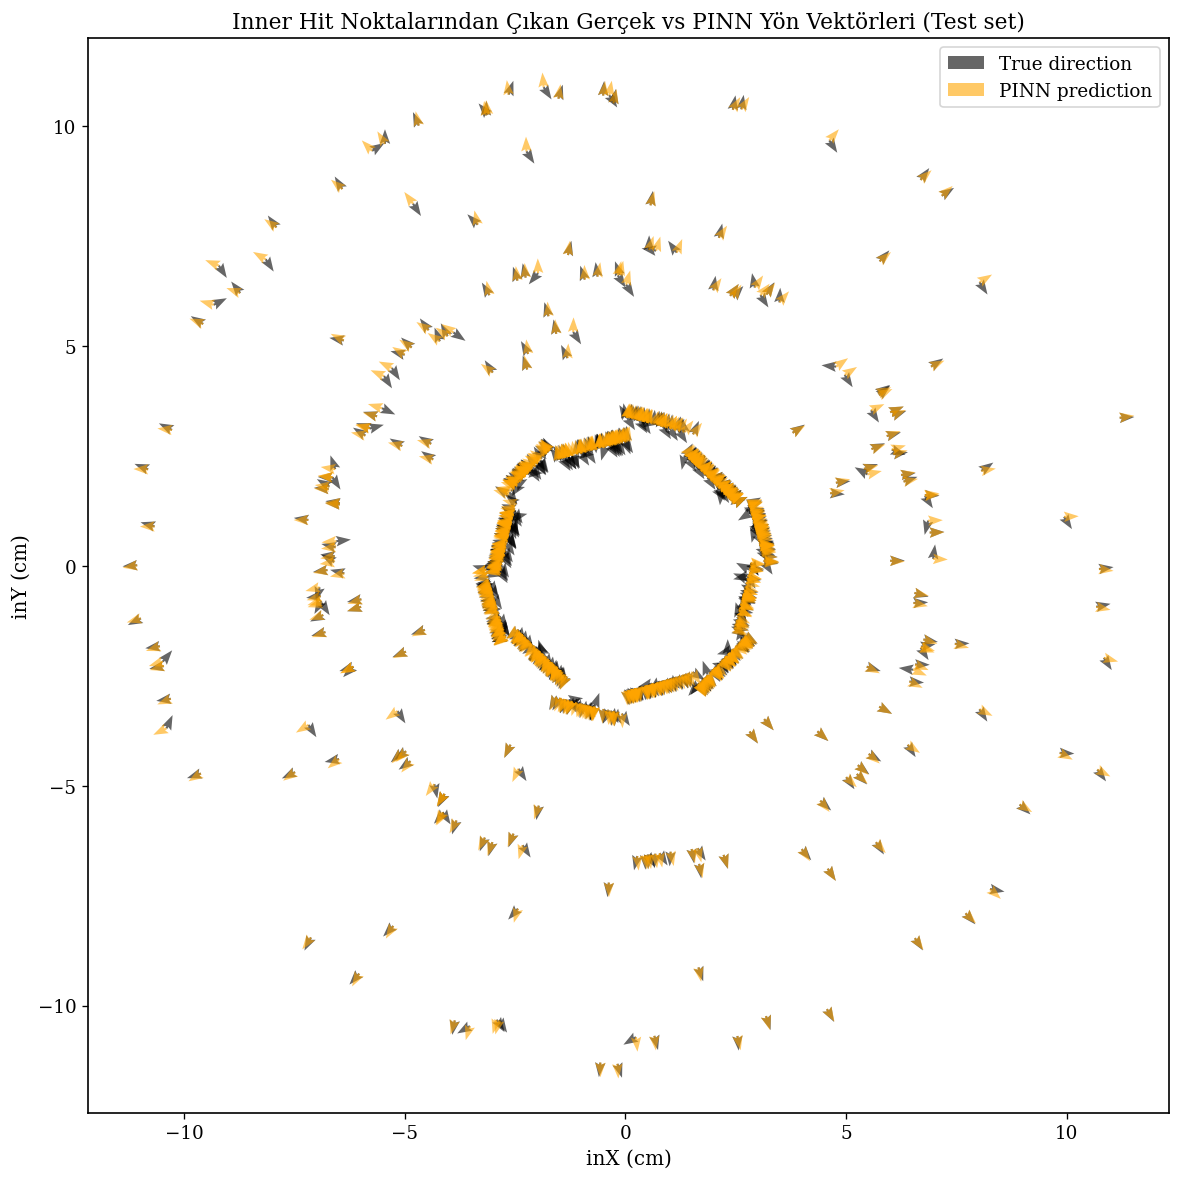

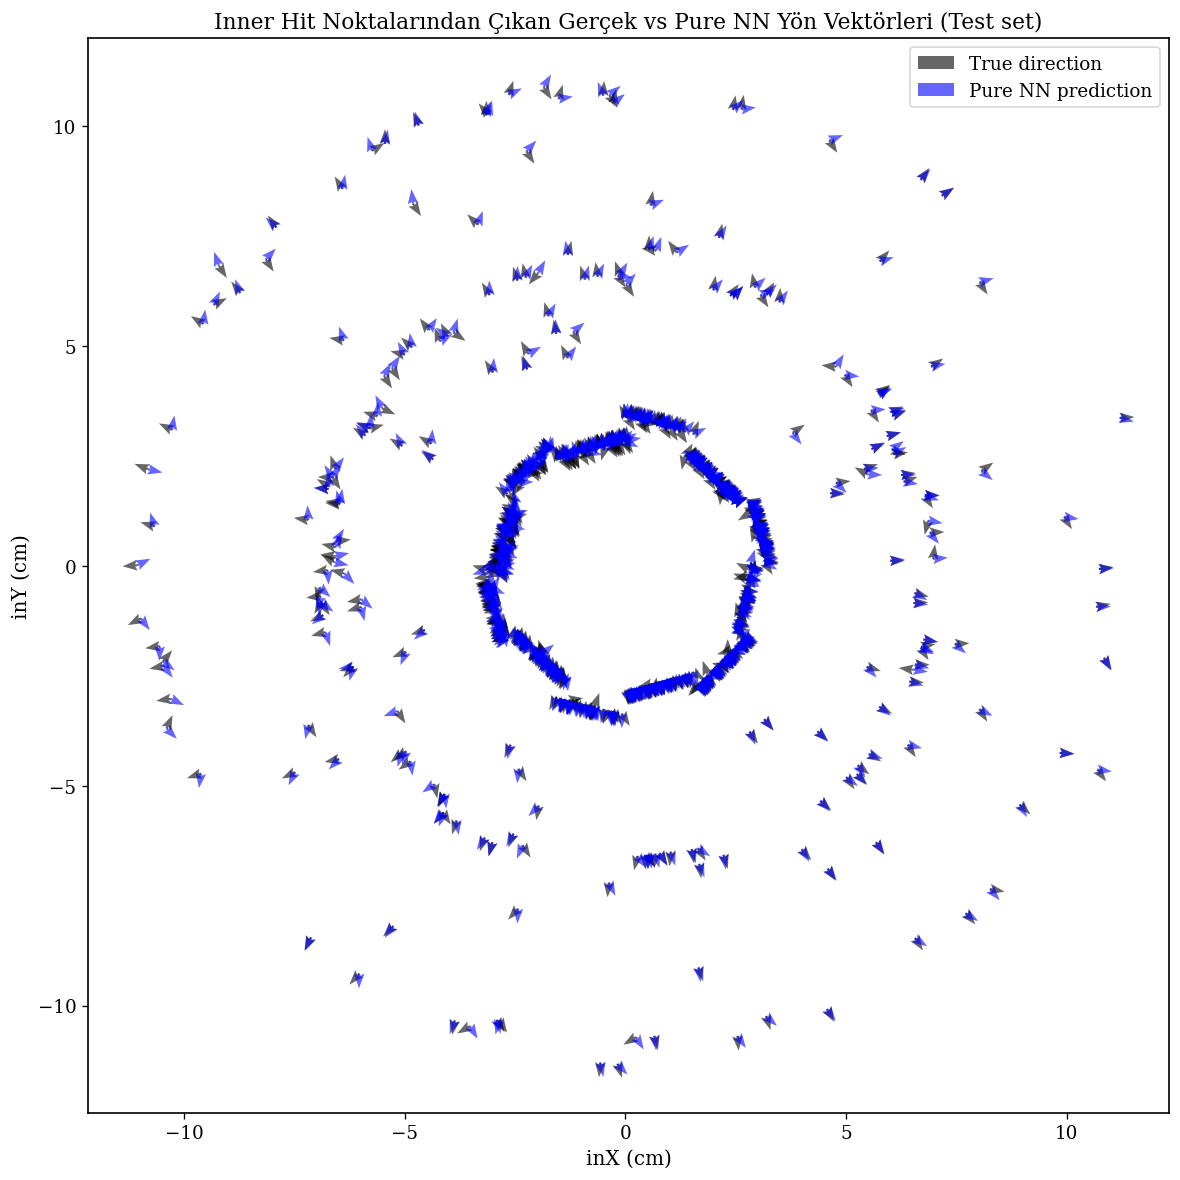

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def dir_from_phi(phi_array):
    phi_array = np.asarray(phi_array)
    return np.cos(phi_array), np.sin(phi_array)

# Plot için daha küçük bir alt küme (ör: 800 nokta)
df_vec = df_test.sample(n=min(800, len(df_test)), random_state=1).copy()

ux_true,  uy_true  = dir_from_phi(df_vec["phi_true"].values)
ux_pinn,  uy_pinn  = dir_from_phi(df_vec["phi_pinn"].values)
ux_pure,  uy_pure  = dir_from_phi(df_vec["phi_pure"].values)

df_vec["ux_true"] = ux_true
df_vec["uy_true"] = uy_true
df_vec["ux_pinn"] = ux_pinn
df_vec["uy_pinn"] = uy_pinn
df_vec["ux_pure"] = ux_pure
df_vec["uy_pure"] = uy_pure

x0 = df_vec["inX"].values
y0 = df_vec["inY"].values

# ---- Gerçek vs PINN ----
plt.figure(figsize=(10, 10))

plt.quiver(
    x0, y0,
    df_vec["ux_true"].values, df_vec["uy_true"].values,
    color="black", angles="xy", scale_units="xy", scale=3,   # scale küçültüldü → oklar uzadı
    width=0.004, headwidth=5, headlength=7, headaxislength=6,  # kalın ve büyük ok başı
    alpha=0.6, label="True direction"
)

plt.quiver(
    x0, y0,
    df_vec["ux_pinn"].values, df_vec["uy_pinn"].values,
    color="orange", angles="xy", scale_units="xy", scale=3,
    width=0.004, headwidth=5, headlength=7, headaxislength=6,
    alpha=0.6, label="PINN prediction"
)

plt.title("Inner Hit Noktalarından Çıkan Gerçek vs PINN Yön Vektörleri (Test set)")
plt.xlabel("inX (cm)")
plt.ylabel("inY (cm)")
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.show()

# ---- Gerçek vs Pure NN ----
plt.figure(figsize=(10, 10))

plt.quiver(
    x0, y0,
    df_vec["ux_true"].values, df_vec["uy_true"].values,
    color="black", angles="xy", scale_units="xy", scale=3,
    width=0.004, headwidth=5, headlength=7, headaxislength=6,
    alpha=0.6, label="True direction"
)

plt.quiver(
    x0, y0,
    df_vec["ux_pure"].values, df_vec["uy_pure"].values,
    color="blue", angles="xy", scale_units="xy", scale=3,
    width=0.004, headwidth=5, headlength=7, headaxislength=6,
    alpha=0.6, label="Pure NN prediction"
)

plt.title("Inner Hit Noktalarından Çıkan Gerçek vs Pure NN Yön Vektörleri (Test set)")
plt.xlabel("inX (cm)")
plt.ylabel("inY (cm)")
plt.axis("equal")
plt.legend()
plt.tight_layout()
plt.show()


Kullanılacak snapshot indeksleri: [ 0  5 10 15 20]


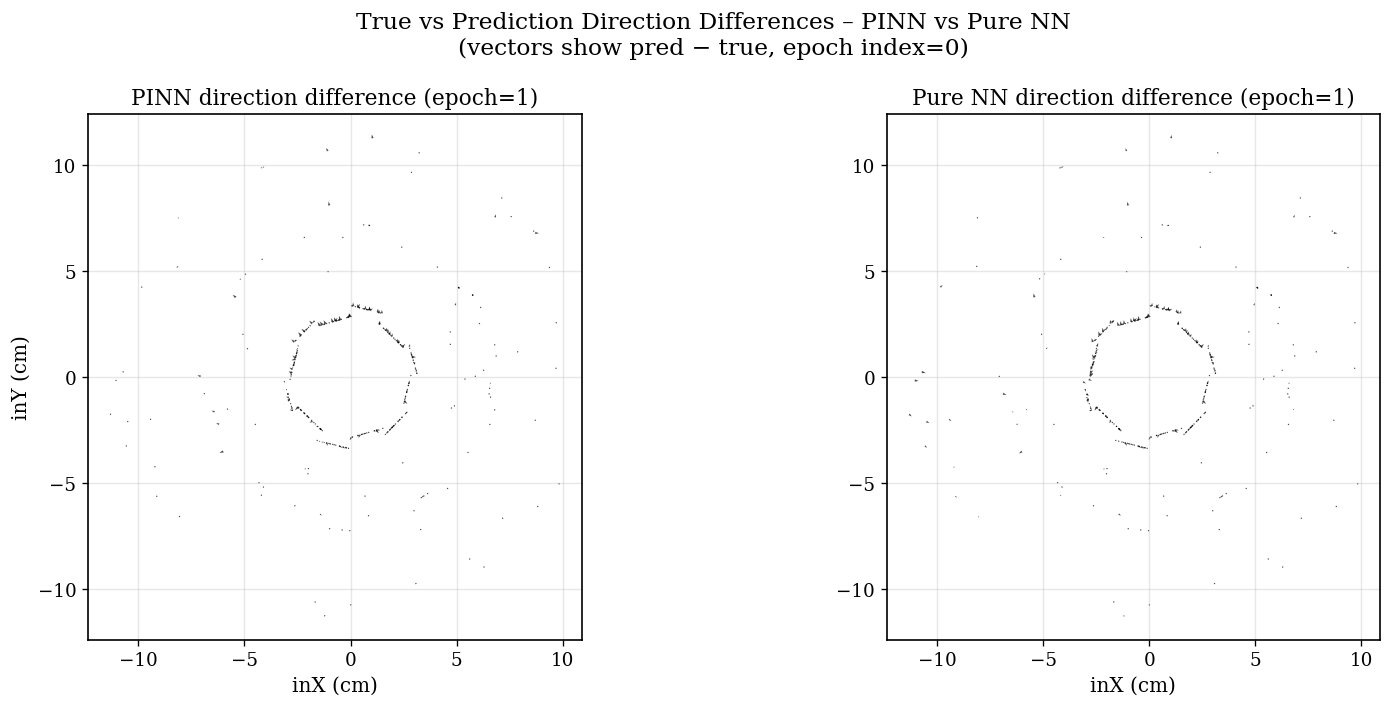

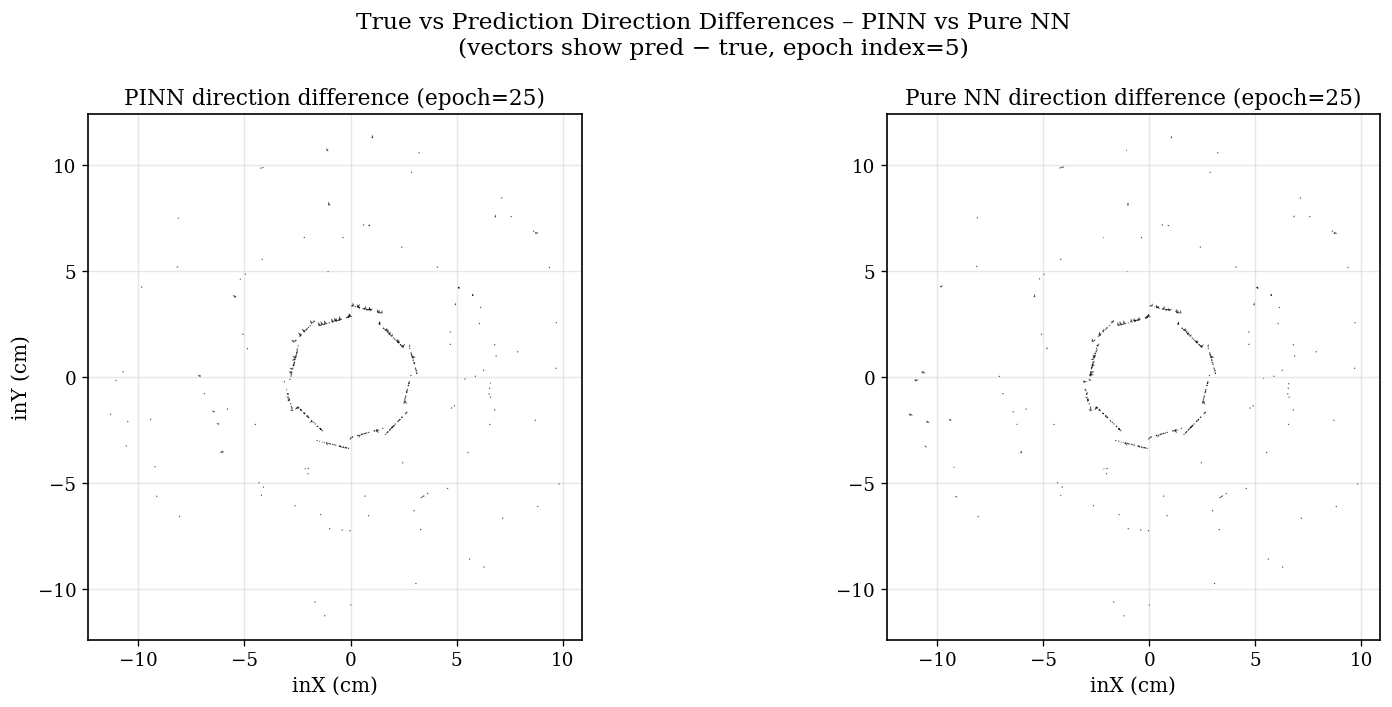

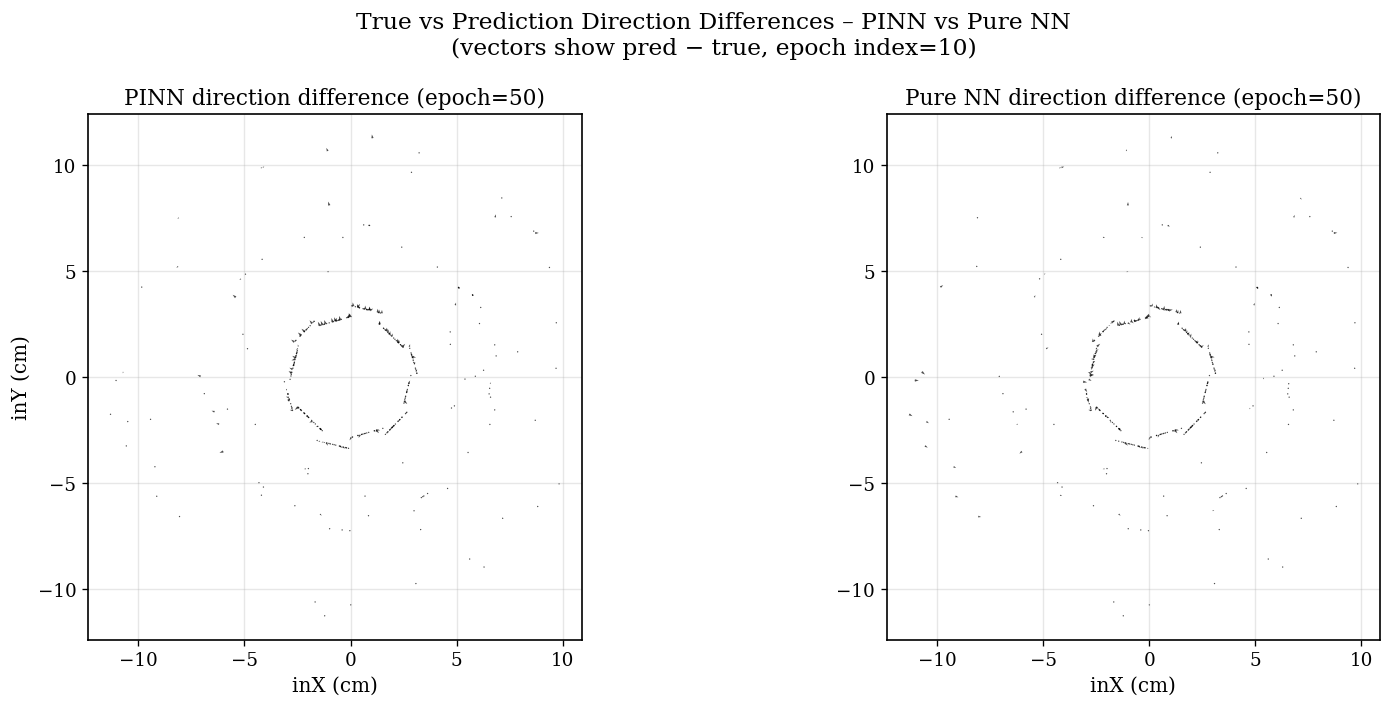

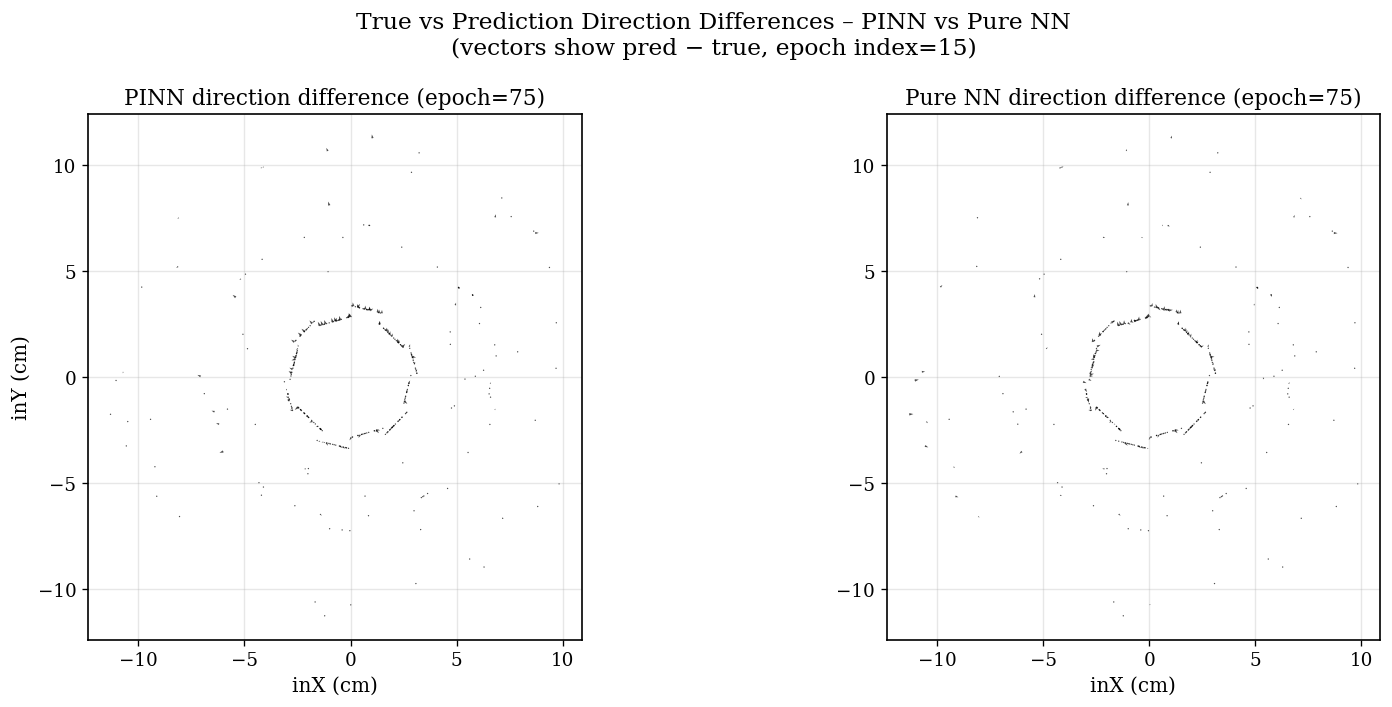

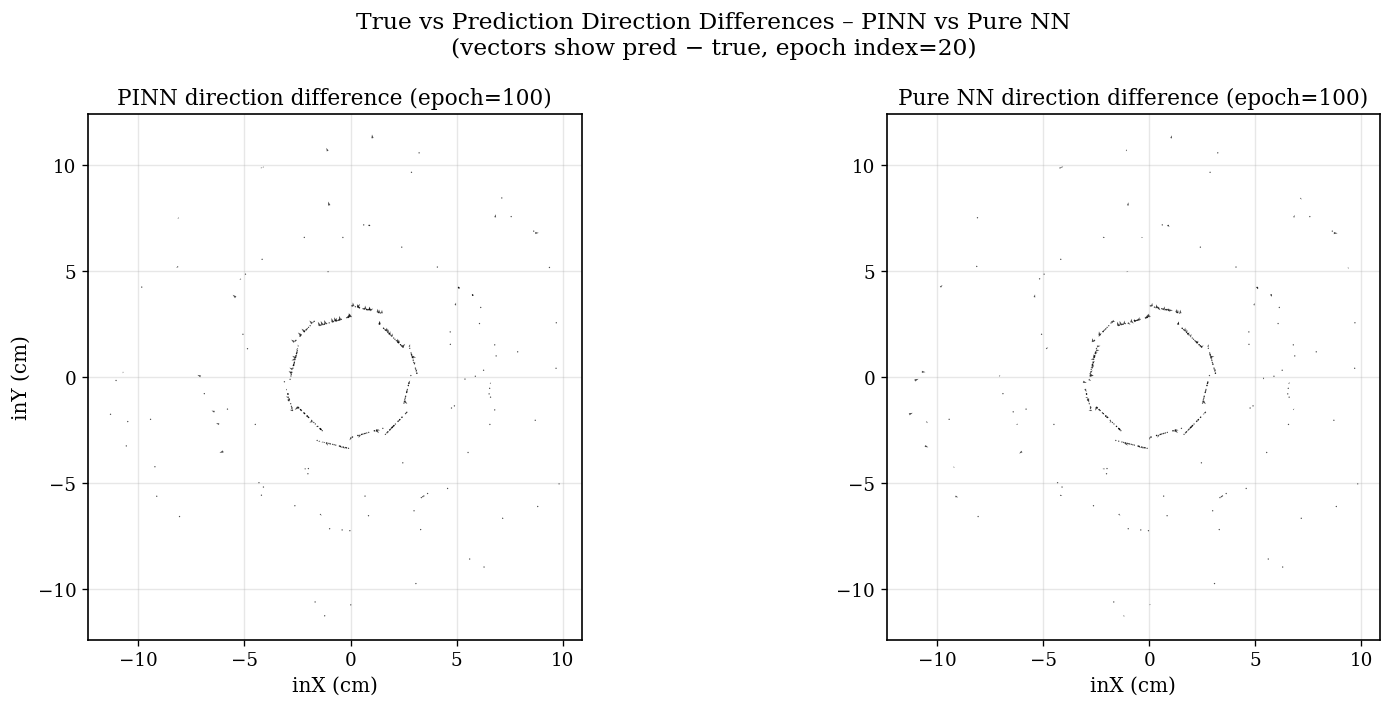

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 1) Yardımcı: Phi'den yön vektörü
# =========================
def dir_from_phi(phi_array):
    phi_array = np.asarray(phi_array)
    return np.cos(phi_array), np.sin(phi_array)

# =========================
# 2) Animasyon altkümesi için DataFrame: df_anim
# =========================
# X_test_orig ve df_test daha önce oluşturmuştuk.
# idx_anim ve y_anim_true da snapshot oluştururken tanımlanmıştı:
#   idx_anim = np.random.choice(len(X_test), size=n_anim, replace=False)
#   X_anim_tensor = X_test[idx_anim]
#   y_anim_true   = y_true_test[idx_anim]

df_anim = df_test.iloc[idx_anim].copy()  # anim altkümesi için inX, inY, phi_true vs.

# Vektör plot'u daha okunur olsun diye buradan küçük bir altküme seçelim
n_vec = 400
vec_idx = np.random.choice(len(df_anim), size=min(n_vec, len(df_anim)), replace=False)
df_vec_base = df_anim.iloc[vec_idx].copy()

x0 = df_vec_base["inX"].values
y0 = df_vec_base["inY"].values

# =========================
# 3) 5 snapshot seç (baş, erken-orta, orta, geç-orta, son)
# =========================
num_frames = min(len(snapshots_pinn), len(snapshots_pure))
if num_frames < 5:
    chosen_indices = list(range(num_frames))
else:
    chosen_indices = np.linspace(0, num_frames - 1, 5, dtype=int)

print("Kullanılacak snapshot indeksleri:", chosen_indices)

# =========================
# 4) Her seçili snapshot için difference vektör alanı çiz
# =========================
for snap_idx in chosen_indices:
    epoch_pinn, y_pinn_epoch = snapshots_pinn[snap_idx]
    epoch_pure, y_pure_epoch = snapshots_pure[snap_idx]

    # Anim altkümesindeki gerçek phi (aynı sırada)
    phi_true_all = y_anim_true[:, 0]  # [n_anim]
    phi_true = phi_true_all[vec_idx]

    phi_pinn = y_pinn_epoch[vec_idx, 0]
    phi_pure = y_pure_epoch[vec_idx, 0]

    ux_true, uy_true = dir_from_phi(phi_true)
    ux_pinn, uy_pinn = dir_from_phi(phi_pinn)
    ux_pure, uy_pure = dir_from_phi(phi_pure)

    dux_pinn = ux_pinn - ux_true
    duy_pinn = uy_pinn - uy_true

    dux_pure = ux_pure - ux_true
    duy_pure = uy_pure - uy_true

    # ==== PAYLAŞIM YOK, ASPECT SAFE ====
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # --- PINN difference ---
    ax = axes[0]
    ax.quiver(
        x0, y0,
        dux_pinn, duy_pinn,
        angles="xy", scale_units="xy", scale=10,
        alpha=0.7
    )
    ax.set_title(f"PINN direction difference (epoch={epoch_pinn})")
    ax.set_xlabel("inX (cm)")
    ax.set_ylabel("inY (cm)")
    ax.set_aspect("equal", "box")
    ax.grid(True)

    # --- Pure NN difference ---
    ax = axes[1]
    ax.quiver(
        x0, y0,
        dux_pure, duy_pure,
        angles="xy", scale_units="xy", scale=10,
        alpha=0.7
    )
    ax.set_title(f"Pure NN direction difference (epoch={epoch_pure})")
    ax.set_xlabel("inX (cm)")
    ax.set_aspect("equal", "box")
    ax.grid(True)

    fig.suptitle(
        "True vs Prediction Direction Differences – PINN vs Pure NN\n"
        f"(vectors show pred − true, epoch index={snap_idx})",
        fontsize=14
    )
    plt.tight_layout()
    plt.show()



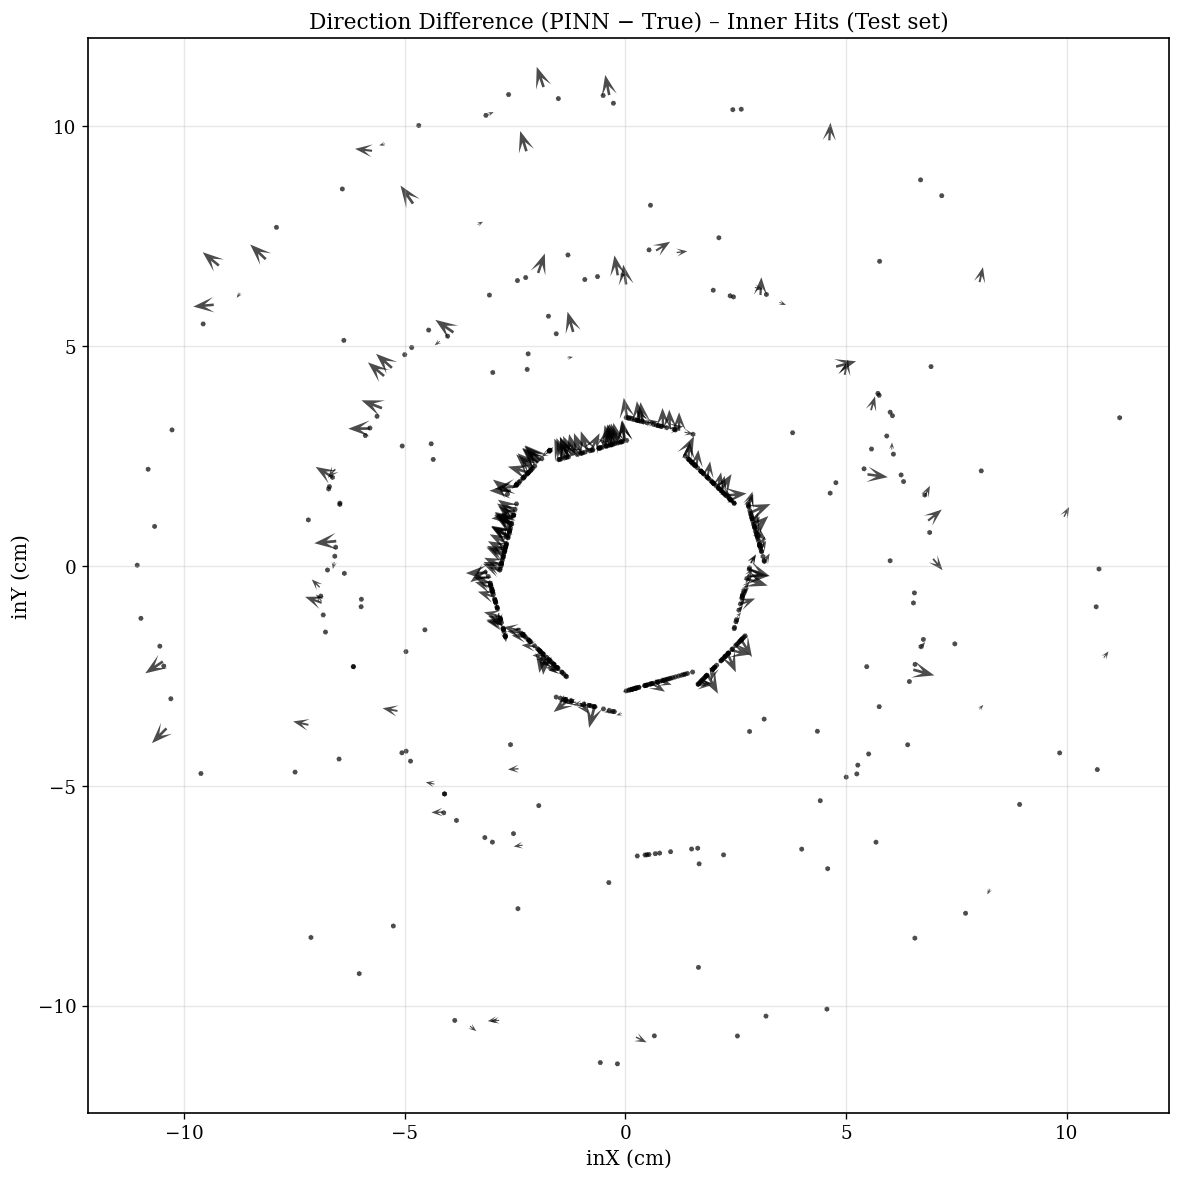

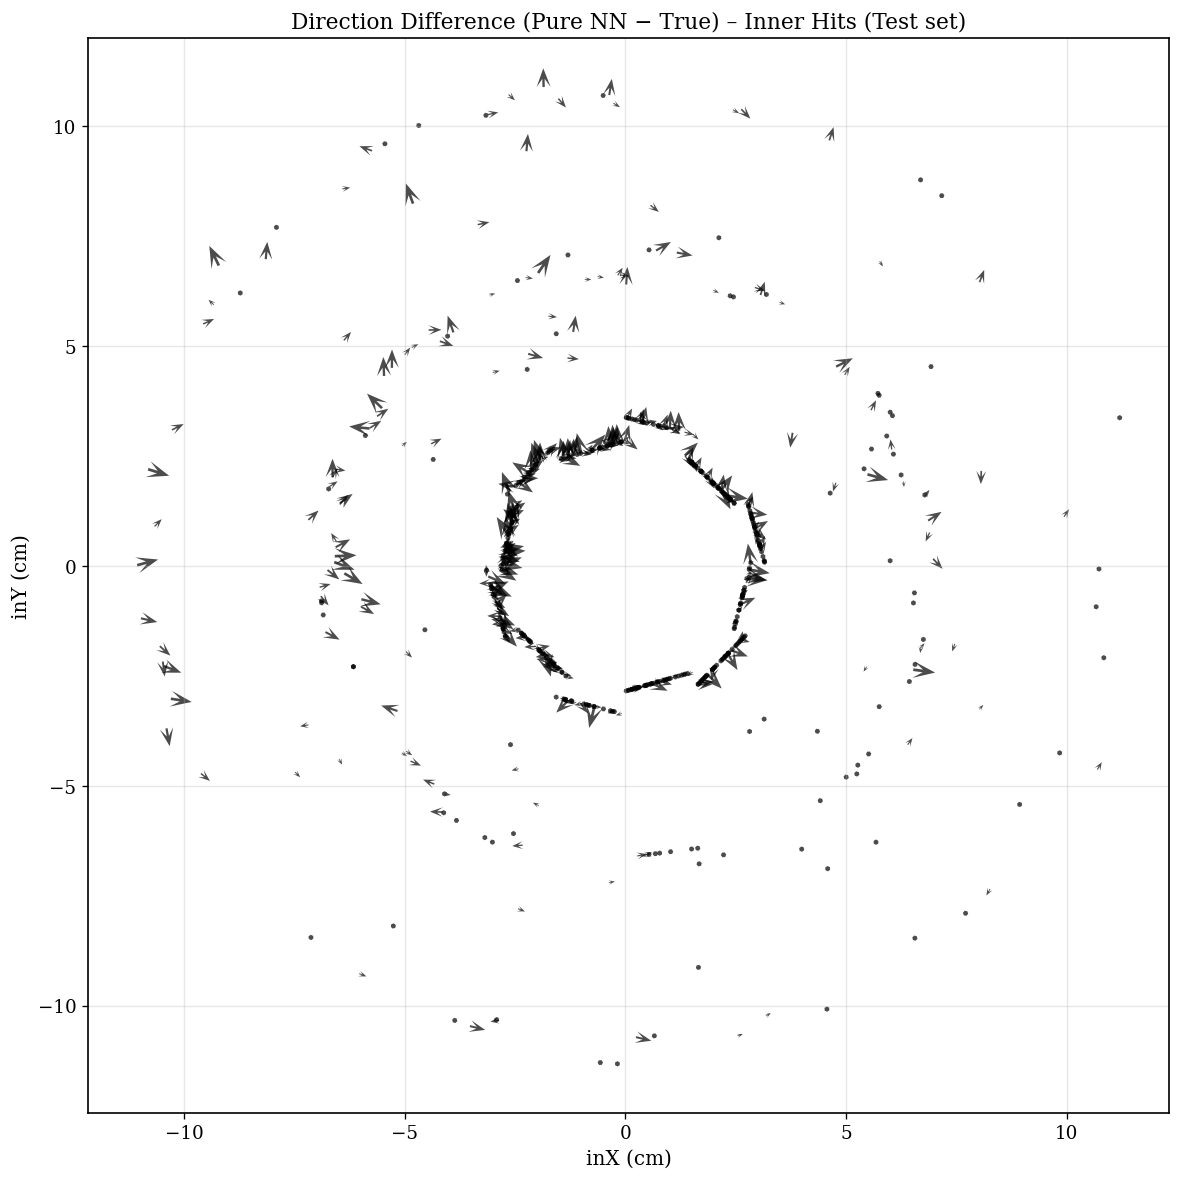

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Zaten df_vec içinde:
# ux_true, uy_true, ux_pinn, uy_pinn, ux_pure, uy_pure var.

x0 = df_vec["inX"].values
y0 = df_vec["inY"].values

# Difference vektörleri: pred - true
dux_pinn = df_vec["ux_pinn"].values - df_vec["ux_true"].values
duy_pinn = df_vec["uy_pinn"].values - df_vec["uy_true"].values

dux_pure = df_vec["ux_pure"].values - df_vec["ux_true"].values
duy_pure = df_vec["uy_pure"].values - df_vec["uy_true"].values

# ---- Difference: PINN - True ----
plt.figure(figsize=(10, 10))
plt.quiver(
    x0, y0,
    dux_pinn, duy_pinn,
    angles="xy", scale_units="xy", scale=4,   # daha uzun okunması için scale düşürüldü
    width=0.005, headwidth=6, headlength=8,
    alpha=0.7
)
plt.title("Direction Difference (PINN − True) – Inner Hits (Test set)")
plt.xlabel("inX (cm)")
plt.ylabel("inY (cm)")
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- Difference: Pure NN - True ----
plt.figure(figsize=(10, 10))
plt.quiver(
    x0, y0,
    dux_pure, duy_pure,
    angles="xy", scale_units="xy", scale=4,
    width=0.005, headwidth=6, headlength=8,
    alpha=0.7
)
plt.title("Direction Difference (Pure NN − True) – Inner Hits (Test set)")
plt.xlabel("inX (cm)")
plt.ylabel("inY (cm)")
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()
